<a href="https://colab.research.google.com/github/psbhargava/CarDamaged-Classification-Assessment/blob/master/2_Check_Location.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

TensorFlow 1.x selected.
1.15.2


In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10249188587996025206, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17605076488002082249
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8663718329217552559
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11330115994
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1975796024747754693
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [0]:
import os
import json
import urllib
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline


from keras import optimizers
from keras import applications
from keras.models import Sequential, Model 
from keras.models import Sequential,load_model
from keras.callbacks import ModelCheckpoint, History
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
!wget https://car-damage-datasets.s3.amazonaws.com/data2a.zip

--2020-04-24 16:51:47--  https://car-damage-datasets.s3.amazonaws.com/data2a.zip
Resolving car-damage-datasets.s3.amazonaws.com (car-damage-datasets.s3.amazonaws.com)... 52.216.244.132
Connecting to car-damage-datasets.s3.amazonaws.com (car-damage-datasets.s3.amazonaws.com)|52.216.244.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10766638 (10M) [application/zip]
Saving to: ‘data2a.zip’

data2a.zip          100%[===================>]  10.27M  34.8MB/s    in 0.3s    

2020-04-24 16:51:48 (34.8 MB/s) - ‘data2a.zip’ saved [10766638/10766638]



In [0]:
!unzip data2a.zip

Archive:  data2a.zip
   creating: train/
   creating: train/front/
  inflating: train/front/0001.jpeg   
  inflating: train/front/0002.JPEG   
  inflating: train/front/0003.JPEG   
  inflating: train/front/0004.JPEG   
  inflating: train/front/0005.JPEG   
  inflating: train/front/0006.JPEG   
  inflating: train/front/0007.JPEG   
  inflating: train/front/0008.jpeg   
  inflating: train/front/0009.JPEG   
  inflating: train/front/0010.JPEG   
  inflating: train/front/0011.JPEG   
  inflating: train/front/0012.jpeg   
  inflating: train/front/0013.JPEG   
  inflating: train/front/0014.JPEG   
  inflating: train/front/0015.JPEG   
  inflating: train/front/0016.JPEG   
  inflating: train/front/0017.JPEG   
  inflating: train/front/0018.JPEG   
  inflating: train/front/0019.JPEG   
  inflating: train/front/0020.jpeg   
  inflating: train/front/0021.JPEG   
  inflating: train/front/0022.JPEG   
  inflating: train/front/0023.JPEG   
  inflating: train/front/0024.JPEG   
  inflating: train/fr

In [0]:
img_width = 256
img_height = 256
train_data_dir = '/content/train'
valid_data_dir = '/content/valid'
fine_tuned_model_path = 'ft_model.h5'

train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = sum(train_samples)
print(nb_train_samples)

validation_samples = [len(os.listdir(valid_data_dir+'/'+i)) for i in sorted(os.listdir(valid_data_dir))]
nb_validation_samples = sum(validation_samples)
print(nb_validation_samples)

epochs = 50 #150
batch_size = 8

979
171


In [0]:
model = applications.DenseNet201(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


74842112/74836368 [==============================] - 1s 0us/step


In [0]:
model.layers[703]

In [0]:
for layer in model.layers[:703]:
    layer.trainable = False

In [0]:
x = model.output

x = Flatten()(x)
x = Dense(256, activation="relu")(x)

x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
predictions = Dense(3, activation="softmax")(x)

In [0]:
model_final = Model(input = model.input, output = predictions)

model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), 
                    metrics=["accuracy"])

train_datagen = ImageDataGenerator(rescale = 1./255,horizontal_flip = True,fill_mode = "nearest",zoom_range = 0.2,
                                   width_shift_range = 0.2,height_shift_range=0.2,shear_range=0.2,rotation_range=40)

test_datagen = ImageDataGenerator(rescale = 1./255,horizontal_flip = True,fill_mode = "nearest",zoom_range = 0.2,
                                  width_shift_range = 0.2,height_shift_range=0.2,shear_range=0.2,rotation_range=40)

train_generator = train_datagen.flow_from_directory(train_data_dir,target_size = (img_height, img_width),
                                                    batch_size = batch_size, class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(valid_data_dir,target_size = (img_height, img_width),
                                                        class_mode = "categorical")

checkpoint = ModelCheckpoint("Location_densenet_final.h5", monitor='val_acc', verbose=1, save_best_only=True, 
                             save_weights_only=False, mode='auto', period=1)

early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

model_final.fit_generator(train_generator,samples_per_epoch = nb_train_samples,epochs = epochs,
                          validation_data = validation_generator,nb_val_samples = nb_validation_samples,
                          callbacks = [checkpoint]) #,early

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


Found 979 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., epochs=50, validation_data=<keras.pre..., callbacks=[<keras.ca..., steps_per_epoch=122, validation_steps=171)`



Epoch 1/50
122/122 [==============================] - 151s 1s/step - loss: 1.2671 - accuracy: 0.3708 - val_loss: 1.1064 - val_accuracy: 0.4236
Epoch 2/50
  1/122 [..............................] - ETA: 20s - loss: 1.0220 - accuracy: 0.5000

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


122/122 [==============================] - 131s 1s/step - loss: 1.1807 - accuracy: 0.3841 - val_loss: 1.0269 - val_accuracy: 0.4567
Epoch 3/50
122/122 [==============================] - 132s 1s/step - loss: 1.0748 - accuracy: 0.4645 - val_loss: 1.0470 - val_accuracy: 0.4691
Epoch 4/50
122/122 [==============================] - 131s 1s/step - loss: 1.0762 - accuracy: 0.4480 - val_loss: 0.9321 - val_accuracy: 0.4643
Epoch 5/50
122/122 [==============================] - 132s 1s/step - loss: 1.0693 - accuracy: 0.4727 - val_loss: 1.0481 - val_accuracy: 0.4699
Epoch 6/50
122/122 [==============================] - 131s 1s/step - loss: 1.0220 - accuracy: 0.4861 - val_loss: 0.9129 - val_accuracy: 0.5207
Epoch 7/50
122/122 [==============================] - 131s 1s/step - loss: 0.9971 - accuracy: 0.5015 - val_loss: 1.1297 - val_accuracy: 0.4898
Epoch 8/50
122/122 [==============================] - 131s 1s/step - loss: 0.9930 - accuracy: 0.4923 - val_loss: 1.0552 - val_accuracy: 0.4923
Epoch 9/50

KeyboardInterrupt: ignored

In [0]:
def location_estimator(image_path, model):
    print ("Determining location of damage...")
    urllib.request.urlretrieve(image_path, 'save.jpg') # or other way to upload image
    img = load_img('save.jpg', target_size=(256, 256)) # this is a PIL image 
    x = img_to_array(img) # this is a Numpy array with shape (3, 256, 256)
    x = x.reshape((1,) + x.shape)/255 # this is a Numpy array with shape (1, 3, 256, 256)
    pred = model.predict(x)
    pred_label = np.argmax(pred, axis=1)
    print(pred_label)
    plt.imshow(img)
    plt.show()
    d = {0: 'Front', 1: 'Rear', 2: 'Side'}
    for key in d.keys():
        if pred_label[0] == key:
            print ("Assessment: {} damage to vehicle".format(d[key]))
    print ("Location assessment complete.")

In [0]:
model_final.save_weights("Location_densenet_final.h5")

Determining location of damage...
[2]


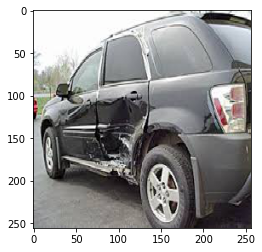

Assessment: Side damage to vehicle
Location assessment complete.


In [0]:
location_estimator('data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxITEhUTEhMWFhUXFxgXGBcYFxcYHRcYFRcaFxcVGBgYHiggGBolHRgXIjEiJSkrLi4uFx8zODMtNygtLisBCgoKDg0OFxAQGi0dHR0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLSstLS0tLS0tLS0tK//AABEIAMIBAwMBIgACEQEDEQH/xAAcAAABBQEBAQAAAAAAAAAAAAAFAAIDBAYHAQj/xABMEAACAQIDBAcDCQYDBQcFAAABAgMAEQQSIQUxQVEGEyJhcYGRMqGxBxQjQlJywdHwM2KCkqLhFUODU3OywvEWJERjk9LTFyU0RbP/xAAYAQEBAQEBAAAAAAAAAAAAAAAAAQIDBP/EACARAQEBAAICAgMBAAAAAAAAAAABEQIhEjEDQRNRYQT/2gAMAwEAAhEDEQA/AO30qVKgVKlSoFSpUqBUqVKgVKlSoFSpUqBUqVKgVKocTio4xeR1Ud5A+NUztgH9lFJJ3gZF/mcgW8L0BKlQaXE4lhctFEN3ZvK3qcqj31Wkwub9pLM/dnyD0QCgNYnHRRi7yKviQKHDpNhybRlpO9EZx/SKqxbPiTtLDGLfWYBiP4nvT1xiscolU9ynNb+W9MRFisY0hv1Ex+8yxr6Fr+6qjpLwigTvMjsR/Io+NEpci7xK55LGfidKgONQf+ExJ8ovxkp0ZUODxEyaSzK6/ZCMf6mb4ivcRj47kqXjJFjZQAfvDUHxtfvqKfaMH1leL/eIVHmwuo9aq4pOI1B18RzHOtdIWK28q2zvlVGDhn0W630LjTUHca550o+WGdpAMGI8qE2lZSSxIynKt9FtxNaucFTcaVm9q7CilOZQI35gCzeI50s/RP6x6fKJtBXaQSRZntmPVDW19DruvRJPlk2oumeA+MQ/BqORdA84umJhI4go4sfS48LU5vk5xHCTDt5sPilTL+mug7DfLbtAe3Hh38mX4GjexfldkP0kuzmkOqmWOa9hvyqjLoN24+NUf/pviuMeGb+JfyFTx9CsXGAqwuFHCORSo8FJIrN8vqHTYYD5XtmtpL18B/8ANjNv5kLC1avZnSXB4kf93xMUhO4K4vfll31xyfYmJX21f/UhuPVLVnNs7CkcgxwxEjeUbtd1gwFvWpLfuGPpD5o40V7DgCL286VfOUW28fGAi4jFoF0C5pTburyr5Hi+m6VKlVCpUqVAqVKlQKlSpUCpUq8Y2oPaoY/bMELpG79uRgqIASST3DcO81R2vj5EXMzBV5JqcoBYkudxsp3DfWbwu05MquipCzqGJC9ZJ2hcXke9zryq4mtbNi8QxKxQ5baZ5CAPILcn0qnLIF0xGNy7+yhVb3136v6WrM4nFM/7SSR+5nNv5BZfdVUOBuAHgAKYa0fz7CB1MMqKwbtM8bsXH2etfUDvvRPHY2NSCWve5sCStlFyA3O2tqw7TGruxNpZGEbNZGNgd/Vv9Vhfhc6+J76WUauUAqCCTdidxHAVDJmsACQCdSLX3EgC+69j6VMJi4sVtIlxbhcb1HiNRQjG4g3uOIDDxHD1086kF0YWK92QORxkvIR4F728qlkxp3DQd2lC3xl9RuOoqPrTQ0QfE1XknvVUy99MMlBM01UGiyXMQsN5jvZTzK8Ebw0PHnUjvUbPVERdXW67txB3gjeCOBoXio7VdnBBzoLt9Zftgf8AMOB8qZIVdQym4O78jyNWVAuKdka6k/mOR50dwO1A3ceI5d47qCTpaqmYqQQbW3frl3VtMbuDGg1cSesbgdoZu5hvH4jmKNYPF3ojQR4o86dJkf20R/vKp95FDI5qmWWgsjZWFOvUjyLD3XpUxZtKVMgM4TaIZA7jIP3tL+AOtXVYEXBuDxFBsFCujSF2bjmHE8bDQfgKMrbhXOtyvaV6VVcZIANN+nlbW9qip5ZLUmfTT9XoRicYApDC+4jXTU8uGoNT4fFdnVhfhfiw1K0BHNrbup1UsNiA5UjcRf4aet6z3SHpE7ucNg7Fx+0lOqxDz0Lchr4GxAIKbb6SQ4fRjdzuRdWPloAP3mIUc6zk+Px2J3H5tGfraZyOQLC48Qo7nNN2fs+OE5heSQ6tK9yxPMX9nx39+61mWUnvJ+NVLQPpPIYcK0XWM5K5QWJLZsRIsYN2JY6A7yadK9tOA09NKqdO2HziGLT/APIhj8RFEZDfn2iKTvVgmzU0tUd68JoPWeoZW0r1zUTNQbrYe0M4jZz+0UC5NrshK2B+0CL6a2Jqrj5o3z9Ucyq1w173voxB4i4qr0IlzLNAd6ssqDx7LL4GwH8VVMPCmHkaFQFjW6ADQBW9k+hBqRa8SexIv3j8ff8AGpBPpQtyQTfeCQfEXDD407raIvmel1tUBNS62gILLwprj9cqpiSrKSA76o8JqpKchzfUY9r91twfwO4+RqdjTGNxY+Y591QQYhKHypwq5FpdCb5dx5qd35VHMlagG3INwbEbj48DzHP+1GMBi767juI5Hl+N6HSR1UmxghIY317JH2l3nwtvB8uNXUbOHE99W0nrGYfpHFezZ18Vv8KN4PHI+qOreB18xvFJUo8snfSqgrnkaVUarZm04ZWyhCrHXW5JvzP51bxm040JjDgOADbkNPzrB4fEPG+YEqeB91qa+LLOGYkmw1vy7/SuE+SWa21J207MRcAHS3xsRu8apy7VZpBY2Ga415KefP41nFxxLPfdc28WN9Kn6zce+/5Vi8++lkF8U5dixJ3i19LC97AePvojs3FdaMrrv9kC1+786CjFXuGO+1u63xvTNr7Y+bwhkAM7q5iDX7CoLyTuB9VRu3XJUX7QNXj7T0ftnajqVwOFP0+T6aXeIEJuT/vGG4d4Olwa9wGESJRFENBqSd7Hi7HiTQ/Y2C6mPLctJIc8rtvd21N+4cvHnRdXCiw9eddWbVkAAbhT9nKHkQd9z4DX8KoPial2diQrSNuCxO3vVf8AmozPbC9IMWXx+G75cTJ6lgvuSrufWs5iMUox8RdlULHJqzBRfti1ybX1ooNowf7eL/1E/Oja+ZK9z0Mm2rh13zxD/UX869i2rE3svn+6Gb/hBoL7NUbGmI8jexh8Q3hBJ8SBUw2diz/4SYfeyL8Wpou9GMZ1eKjJNg/0Z/j0X+rLRjpnDlnU20kjB80upHvFZebY+Ktfq8h3gs8aWI1B7Tc61vSnFriEhEQ62VD9IIvpFjLoCyMy3Aa+U2vu1ouAGKe9m57/ALw0ProfOq6NpRCHYWMO6EgHfnKgehN6uYbofiSbsY1H3ibegpqYDBq9DVoh0Lce3iY1HcpPxYVPF0dwiftMQ7nuCqPgT76auMtmr1ZLVqG2fgR/lu55tI3wBtTCuFHs4aLzF/jTTGbbErxZR5ikswO45vugt/wg1ozjFX2URfBFqGTaTnjb3UANsLISGEbDQjUWJuQdx3DT3044GXihojJiifrH1qnPLerEUpMG3HKPFl/Ohe0tldYV+kVct+bX9KJymhW1JjYIujOSL/ZUas3dpp51b6IGz4CFGAbEDXs3Ck5NNM4tx3DvIqYbLhvpPJ4jDyfHS1QQsCpVMvVm6k6MW56fiabCb5o3LMVIGpNmU6q2ndoe9TXHyjeCa4IcMViAOXVS/wDyV5UMcKgABPe/50qn5DGtSfNcHlz0vUWFKElZFkuTYNluBzLW4f2ookuGZQ2aazE2NstyN43VJ12G/wDMOm+/A8L+QrPU+4zerl9hs+HAkyA70zKctgQCN4568KFdItrtCiIhUSuWIJ+qi2DMFO9rkAeZ4VpYzC0qhI5GORxvO66W1voNDWb6SdE58RllPzYShcnUsZCCAWYMJAew2tiNRoNeFOE29LPW6yEm2sUd+Ik/pHwFasvK8MTzOJMRjZYYTa3YgR83VhRu7Ksx5lzWGnwmNE0kUeGR2hYK4R8wBtmAFzr5cjQzZOEkmlMt+rYuSWtazXsQtyOOm/nXSSy0dlfbKAuQpZV3sCN/2VHH+9WosajAMGAv9rs68qzOD2QgjVZZHYDU3dtSf3Iwt9NAM/CtNs3ZeDy3Vs9iCQEVSp4XD52B86S21jxMfFX0UZj3An3V7hcFJI0kbZ1V4mUtl9n6SJjytorUTM8C3UAMRvUuWtfddb2HmKbLtVepdFVMxaPsgAWQk3bQDTs+6tLJjNYToWOt658zNlK5WeJFAZsxOiuSdw/60VHRuHjHhR95ZJj8UFOOOUe0yjxI/Gmf4xFuEieTAnztTGl3D7FiXcyr/usPAnvcOavR4Zd3WTn/AFAn/wDNVrO4rpThYv2kyrfcNSTzsONDm+USBl+jST9oI8zAAai+cC98o0Gopg2owcXFXb700rfFqqYhcMp/YRX5lb/GsB0j2zgZwExM0mXXsCQxq3eQF7VvGqmytv4SAGGASdVlDJZne7MWDZSQezZV0HEnnVwb1sZEpusMIPdGnxtUPR/arGNzopfETk20HZkKA6fuoKzeG2kzorMpUnWx0IHC44G1N2ZjCIzbT6SYesrUxGyO2DzNRNthufvrMNiW51H1x50w1pJNqGoG2iaAGQ0g9XAbbaPfUTbRFB81Nz0wGDtIcq8/xD92g/WVNgJz1sf3h593nu86YlGtl4XEYonqUXKDYuxNu+wG/lqRuO+xo1H0InPt4gD7qKP+LP8AGvPk6x6RJiIZGA6pyc3NScwbwOb3GtlhNpwykiNwxAvbXduvrUak61l1+T9frYiU+Fh8LfChO2Oi2z4GAkMruw3Zg2l7a+fwrY7bxU8esallP2bAr94m59AawW2nklkjlIJ3hjcsFIzaXsLbxwG6scr038fGcuWV5DsXAXsmGa3e4F/6TWS6dYFIn+iTq1yNex17JjYXI36F61+GYZvDvFue/wA6z/ylIQgO66txv/ksQQR3rXOb9t8+MjCLFIRfJKe8LIQfMUqodYx1LMT3saVdunF0nozh8jyfTxsXAIiVybFd7BeVr31rS4DDq7EZrAasQCbA6WGmpJ4VifkykkxBnkYKBHkUaBVJfMW9lbkgKPWuhIqoE62QIgYyOULHMF0RQbAk+1w4mvL4Xz7nTv8A7OXDn815cPWRfW4XJEgjXiW3nvKrqx+8VpgiUe0WY/yjyC7vU05tuxOCIju4WKnXcbHfWf2xtSyk5iuo1G/U8K9nWPMNRzrGCIkWMXJ7ChbniSRqSeZrM7Z2Jgp2aR1CSfWkQhSe9tLHxIoG8uIZu0xC/aDXJHhw8aobSwIBL4vFdm5KwRlpHI4AKbImnHWoC+HlhVhFFi5JjuCCISHxzAgAd50pf47Hhy+XM7m2Zrr9XdGMug1JOhPjWSxe3QFMUKCCM71U3kk75ZPwFDXnd9FAC7rjdbu5DwrOSNdj77daJg0MCQ5g4ZVKkuSQRJIQDmA143Nzuobido4mV2LyXK5ALEqNzWJC7zv31XigyqBy41FhrrMyn6yZhe3Bj/7jVMXnx2KuMrZSORFj4qVt50pto4phZ3QfvKih/wCYDSvSKgna1IKj2W54nidSfOqsMlpM3r4U+Zr1DWoo1h8SVN0ynI4azKGAYWKuAd1Fm24ZVK6o5vc38yRYDv004UAwqg9viRlI52Oh8aeG41NFxNpSIwyHTSykk3vzud5o9hNoqvWK/ZtIxuASBexINt2+g+yNkTYiSPqonKM4UuBdVyWLXbhYVsOjGChljbEFc/WTTFCd2QPlUgHmFB86JVWKUMAU7QO4jjUywOfqn0rTAAbgB4U5CauozBw0n2TTWhb7JrXXpjqp3gU0ZBrjhTS1aTE4ZTyoTisIOFEDWao1lysGtexBtzAO4d9OmQih+IxqIe0wGl9e6qNlDiRFio5d8cy9VJbje5Rh4gsB96iUeN+bS3vcxnh9ZTy8VIPmKw+ysecTh3jKlSv7Nid/FSOIKtb1HI0SxcrYvCrPHfrFHVyKNLENa55Wa6911rPP9x6/8d4+Xhz9V16LasTZXDHK63UgE3HO4rOdL4MMv/ePpWlZwABLLGOC3IUjQaaUO6L4kzQ/MRIyOg6yNlYi6jehI1tqT591VdsYJmQpdi6utwWZzYHtWvc7wK471/WJ8cnyTjy9IIdsODdQgzW3jNy+2TQT5R8SxgDuQT7NwAN6yKNB41ejwdiLsNOGunlQz5SI7YRRobtHa33mFJPTfy8ZPTnWGjuoPj8a9qHDu2UWP6vSrfbzu27J6PxQLljGVb3sNBfnYca598pPSSYYlsNFIUjiCqchsSSMx7Q1G+uvxGxF+dcN2pg1bauJWUfRxyM7jddVsAt+F7qPOtWMwN2J0hmSVbzMdbAkk7+DX3i/nrWx2jtk5OsJQH/Lj9oljpcju138qtM8UsAMcaqoGiZVGUbivZ+NZTFgKwI1vx8ONRRSbbUnVkIGV7AZgCCOe/ShkzzzEk5iTvsp1/l30c2dOirnJmDXAvGIrAW0uXU61c/7R23YzaK+DYcfgKozGF2DNvEErHuhc+nZopH0exh3YWc/6bUXHSTW3+J7TH/oN8DU46R6WG1sbfm8IPwb8KAL/wBl8fwwc5/hH4mqK9Fce+NjiGHKP1ZYrIQoCXIzE62F6PSbcc//ALvFjwh/I1iNt7SlfGMwxUsxGVOslPVlwBqLa5RfQX53oNliOhO0UGsCkDisqH4kVmNrYORCoOS5GYgOpK6kWbgL2J40ptoyAHMk6G+imeUC3kBmG+hkUmdrDq07yhb3nMSaqkY9bF0H8X5U6KJcwuyHXddjfu0GlFVgeQiNcUhB0yBZEB0vb9mBuvvNqjhwDK3YnguLj9plNxobEi3vsapqXB7PYr2MrceywbTvBs3uolsbYZlINiVv4D1qPC7GxJKjqWu18rAm264IdDa1yOPGtvKViXIzaKLG282GoJFrAa1jlQM23PHgNmySREq8xaCLKSA2YfSuByAvqeNudebG29hcPhMPE0oLLEtwvAnUgncN9Y7p5ilnMKxPmSNWsCT2S51te9vZXT0qnHtCPRVTNYey1wq8r/aFWejHTV6RKDYxkbtSwI13HTgeYvVpdtX3Kp8Grk0238QwPaVRu7KgXHDffSoxtjEH69z91dbeAqni6+u2k+spHeCGH4GplxquLoQR+t4rkMe0Hb21F9N2m7w41oNg7Rla4SKRygvdASwBOmbgaSxMbeSWq0klR/OSLCQNmtvVGa9/uA2NQPiL6BZT/pS/+2qiLErQDFYUNOC1iqqDlPMk+u6jGIklt2cPO3fksP6rUCfZmLzl/mshfUAnIFW/IZrmmhuI2sInGVLspvbQDduo9svayJKHUWgxIyuBwdhYX4AsNPvKOQrLv0bxpNzBJc66ZT4/WqWPYGOVWQYebK28WH56agGpvWHcss+mu6MbKxsOLEkUZkCtcyZhZkNrnUjUjh4itwIYLPnjLu2pJPZuTe1lNyQb+dAuhe2MTHAY8TBMDYgdkElrWz77Wbedb5tba0UG08oBXDzZhexvGPdc+NcMs16Pm+b8tnK9VYclbLGuVSL7l3jj2tawPylkiFAALtIp4AXGY300rT4zbuKa30L6brvGN/Ow3Vn9uwz4loi8KKqMuYK9yVvZrAgDNlLcd9qSXXLpz7DbMbKL9+4MePhXtbpXwy9k4XEaE8CeOmvWV5V8qY6CD4elcs6Y7P8A/uGJUaNiDhQDu0e4bX+C/lXUFYVlemmGBxGCkt7Uyo3eFPZ/4zXasT2rbZ2fDBBAY4xETJNAwtq3Veyzg730a5/erG42EHDOcozRzjtWGbK43E8gTurp3S7BfOYWlZsrQs00YAH0g6rJIWG8NqNeYNc0U5o8UvNY3/qIv7xWYK+Gm7IIJHA20qT5w3M+poVg8RYWJoguuvwqqm+dSfa9QD8RVbE4pgdVjOn+yj9fZpO9u6quLfQEa30oLEkwB/yiv2hGTpv0AtrwoftnDRSEvCMpW5ZLNdkvoQeLW0Ip5WxKkgEaWY2IsffXuYK2ZQCLcSRe4F91ja9MEe1Z8TIQ0zu4YdgtuKg2GXhYcqoqLH8P1uokqM6Lh8xzK94x9XK6nN3i9k/lNCg5O4E27x6VVEsFtFonDEK4ysArC/tKUJvzAOldD6OdH9n4yAfN4Vjm7RePriXjy6ADNcuGHasedcvwsTO4UjnZbE3sCdbeHuo7s95ogsiF0yP1gKjc4OhvxA997UR0DZeBOEJRjYXN8oNiG0VSDw5+ZrFba2j10xizm3a3C5YjUkeJ0HgTyrX7f6SCfCdbezntPYWBZQy9kfetXNMOxDPICMyLxvoQL2FuJJ3VMWIMTcyFRYZTbSxFxvAtoakxS5RlHtEXbw4L51NsDB5mF+O/43o/sfojJiGM07GKNjdVHtsvDeLILDjzpvbXqMlGlza9EoMHxtr4V0nA7Dw0I+ihUHi1wWPO7Nc++n4jCjnbxAI3bh33tv0tUumudCEA+Qrw49YXDCXI41GW5OvMDQjxrUY/AIdHSxvpl4945+6s/tHZAHI28ND676mGtTsLpGmJU5W+kUdpdR/Et+Hwox86LDU61yZDJA4kj0ZDfy4qeYIuK6DgscsiLKnssPTmp7wbitMVdm1qqyjkKfJJUDvQKpI8W67mqvmrygKR7cmHEeYqwvSSXlGfI/nWfZqYXqg9P0kl+zH6H86Gy9J576CMfwn86GzObVFhCuZw24xyAX4NkJQ+oHrWKsgoNv4j7ajwRfypUIRzavK56rrivWf6cNaLDzf7HExufum9/gKNg1T25hTLhpY+JW697LZh8K7ua10qX6LELBIwkjUOY+yQYnkuxU20BTObcxXHME/blUccM39BQj3XrpmH21h/mZnsRiRAIGbUrIigqlzuuASOe+uS4acRTqz3y9W6nTdmjsPfastYtbN2jg47ddglmH1m6yVWv3alD6CtJg5Niz6r1+HO62ZyB5qWHurE4JFfLED22JI5C1yST4Cj+yNnxwGTrOrlDgdgi4WxvmF9503iitVH0RjlB+aYxZe68chHcQuVh6ULx/QjGLfsxN/SfRh+NDpsRBvCBSNey27w1NvKrmD6YTRaLO9hvDEOPRr07FUbIxkaMjYOV1LKwsucIVNycsZJbMNCKG/4SpJVpSkoNuraGVCCdbEH2POtzgum+f2o4Jd3skwyemqt/KKItt3COCJesjBKkiWLOLocyEslzob2uBTaY5xN0Rx5CtHC50GoeI3B/jv7qO7Bwe2HQRrhorx6lsQEJZToqqtrg+eum6ugbImhYEQyQTA5uyHzN2rk9lmDDfu4VT2rjWwavNLiCgLC0ZyoBmawVBYllF++1rmnkmAeKw2KZla2FhU6NFmKtYL2iHfKAx1BVvZI41Xh6PqhkGYpcAEFlYHMLgnKSDzDLa/KtbgtrfObssmFmRcquqSXa0lxaTskFSBfS261DMeqzNLh8NBGZUy55GARUUL2Ig0QUFtLjMD2T508oZWU29GggKKwLZ/YB1tYsGK/VLWv376xeMjlRniYFDoHX97MSQbcifdWqxezZ4XYYhMjSTRWIKsMrEgsNeAPG26gGIhOaRn1dmBuRqWez3PAHX31djUaLoRgAFMrbgcqDm24+I3edFNq7ZI3br8D+PE0pnGHjSIfVXL573bTvJ99BNi7Kkx0xVWyRLq72Gl+Avpmt6cd4FAyXa920NgOTb+/U1ZwnSB0Ns2ZTzt7jWmM+ysEvZw6OBoZZSDnPHKSCzeQt4UbwXRfA7TwiYlYPm5kzZDH2TZSVDFbZXBsdCL94qbqM3HiklTTcfaW/wAba0Lx6shuDmudAL2H3mtodLXNr30FP2nsSfZ8uV+0hJySD2WsdRruI5Hd376tG0i2N8p32I09xse8a8qYMvioVa44666EX35Tb9Cwot0Ijh6qZJFkzCXNdHUWVlAAysp1zK2vhQnGKY3YMBa+oPEcL7z76udFsQBiMt9XQgjeCy9pSD4X9KFF8Q4DsgvYbr2vY87VAZK922csitzFj+vKqnWVRZD0i1VllqTrRVRJems1MMy1G068/dUDJzUCWuL7r+7nXssw51B1grNWLCmlVY4gDjXtYwddaU8BaonmYcajzX3GvCK61hh+kWyJVLnDoWjclmUHVSTdsi8jr4XNYLaKTF2ZonBJPtAjf3V2yUb7b++qT4JW9oA+NZajkOzkcXaxDWsO4HfV1kkPPuro0uxoj9UVVm2Gh3ae+rqufmFudNMBHOttLsFeBHpVSbYJG6x91NGTaO/C9T4fGzJ7EjDuJuPQ0TxOzmH1SP1zqi+FNBMdrZhaWFH43BK687WIv4WoZtDFmbLnDXTRSXZrDkM19KnaE8aieGkmKl2LttsKzlUEiuhRkZuybkEEi2hDAMCLG430c2N0nHzgyKSjMtijuUV2C6uTquY2t2u4bqzJwtQvhqo6Hi4Uld5JVxEcjsr2bKydYNUHWR3ATW2gFDYYb4lhKmQtOt0OtiLWUHwUa7tazuF2vNGuVCBoBfXUDQZhfK2mlyDRTZu3JJJsMrqo+kVSyi1wx7IK7rg8RzqWAx0jxd1LHcVzKRyb2h4b63/QLZqwYYAZWbQyDeCXUOVNxroQD4DlXNekyXDWtbcbC1tD+d66LjtpfN51JbsjDsxjBF3CsSSoO8gX9anJGK+Vfo1LHImIjYnCP2BfUYVv9mbfVO8HnpyrsfR3AjD4TCwD/LgjBO65y3Y24XNz51n8ZtgpGs0bRNhnQEu3aDAnTKNQW7iOdT4YTpi5EaWaRJoyysy/QxnshcpA0OpBF+WmlBgo+lXW47EYPFWODnlKo/GCa+VJQeRYEEd4771epeCWSCQdqNird9txHMEWPnUGK6P4mKWWPFQSFTmUusTlGVjo2YAjkd9FcY7S4bD4h1PWqGw8zEEFjAcqS6jXMmX9CnG/TXKZ6AdtxdkProbGwJNjy5WoVs2XLiIGIItIq68nOS5/mo7iVuGW9wV3jw105issWswPEMrXvxRgd1aRr+ka9lT4+7Whav76N9IvZ/i+IrORHT9cKn2fSwGr3rKhzU0mqiRnqNnqN5KhZ6BzvXkQZ2CL7TGw7uZPcKrSS/r8qMbPi6pS7ftGG77K8vE8aZoOYd4IlEeRWy72IBJO8n1pVmHmJJNKnlP0mOsHSme/4eVIsPqk+ZqAk31PpRDi3lTdKSmvGNv1eopOvdUDR91Sh+7+1eG57v131FQtD3VDJBVhg2oB7tNf0a8K0FJ8ICLXvfn8LVSl2WjfVI37udGiB3UxlBGtzUVl8RsYcBf3UOnwBXhbh+jW1aEHcKhkwHA8fCqMNJhgd41+PhVV8PzvW3m2THe+U351Vk2QPH3f2poxL4WmxAo6Pr2HR/5WB/CtXiNmgb1IGutUZ9lciLHmCPfV0FdvQZlcDiD6jdW9bAx4j5vPkUtLA8eawJGdMw14bz6Vh8PrGoa17AHjqBbQ8Rp762vQrFF8M8NzmhbUaaxuSUPgDmHpUvaK2xtntgMEsb5JDdpJCb9WgJzMgNiXI4aAE66CtDtGZjGsSyXzRiRVVwjsh1A5re4+FVdrdJY8FGWezF9BFoes03WPdepcPiIsWkOOhfqlIB6kqMxK5kKkjgutuFBLszFTiJesLo+oK5jwJAJANrkWNUemZMuG7ZzZXXfya6ndrxFYbb/SLHYfaM0PX5YkysoZFYMrKCCLi+pvx4UU2Tt2fF4OZpsgAxEccbKuW9h1jE6ndpSLnWstiIRGwC7iOd+J0vWa2mfa3aE95Ol+VarbhIIzCx8N+u+sfj2BdtBvHL3VtHQNuEGFTzCH1FZpWAJFr+dqO4x74SM80jPuFZ/627gb/hWb7WejzIPsj1P501pR9kep/OoGlIF7Djz4VVfHHeAO6k7MWpJRyHv/ADqEEsbKtzy1qrJiCeAq1htqqgt1ZHetiT39q1/WtIIYbDLH23tm4Dl68arYvaOa/aAA3k39wAuTUeIx+HKkgySOdyt2FX9421bwvQlmvv8Ah+HCi4mOKPBWPfu93ClXiu4FgTalTB2bNzu3mP7VKADuFV423WFS3O4k+WlGEpXy/XKm2A3616q23bvWk1uG7+9QQl+Q/V6Qbup6nl+vzpWOvpWVRlajK8/xNWChFNtysaKgyd+vxrw959/vqcpe278uFNEf/WgicAcb9+6og1+8fr+9SSL9kG1eiE8gP1woqInTd5i/Oo1XfperTRjnSEduF/1v076ggydw/CoZ8ECLAW04URB0vpYd3hfTzqF0B3UASfD5A2ThY+7XwqxsDarQSrMgzWBDLp20PtL47rd4FW2hOnI+nge6s/iYjFJa/ZPsm+63M935VqDpuK6NYXFATxgyRyrZgTd1t9aMtqrjium6oNh7BfBxvHmEkJkLRuNCM47SOv1WuL+ZrO9HdttC10bLm9pW1R+Rt9U94sfGtjL0mhdLSRODpqoR93JiwPrTEZPpx0RlxzwyYYoJQDE+clQUHaViQp3XPrUWJwiYWBMKrFxApaVwLZ5ZfbbyBHgABwNHMbt8BWWBWW+9nIvpyVSR5knwrI7TxgG5twu3HMrbzrvvu870kAHbD3YC9wB/fTlvrJTsM3G9yb3otjcSTmbnoPE0LWO+vl5DefM6eVaabOLXAxgHURJp3i1Ao2AJzHKLcTbytxoQcbIvZV2AHI2qMuTqdT361nNQRxeLVlyqDb7R09BwFVL/AK0qIV7lPrVkweMaYb1OIDpp+vOkIiDa/lVEQHfT1FTDCsdbDfzrwxkcK0EF7qVSCJjuBpVNHWhup44+VKlUc4ff4ilHw869pUVGP+b8RU8f415SqVTEJzN+uFP4nwrylUDyN3jTJvZbxpUqipYhqar4g9o+IpUqK8j3+n4VKPZPg3xFKlQQk9sfrgKjkOo8PzpUqtRFL+JodtdR83c21CgjuN94pUqk9gRhD2P4yPK27woiHI3EjzpUq2h+IY3AvwPwoHtFj1W/6xHkCbClSqqzeK3r51XmNka3L8BXtKsVpUhFSgUqVaSJyKeh/XnSpUVIzG+/61J99KlWoi1htA9uf4VEvteQ+FKlWQ8GlSpVgf/Z',model_final)

Determining location of damage...
[1]


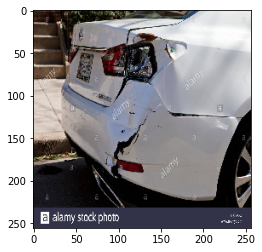

Assessment: Rear damage to vehicle
Location assessment complete.


In [0]:
location_estimator('https://c8.alamy.com/comp/EKAP5C/car-accident-damage-on-rear-end-usa-EKAP5C.jpg',model_final)

Determining location of damage...
[0]


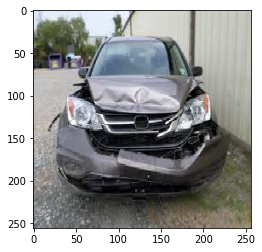

Assessment: Front damage to vehicle
Location assessment complete.


In [0]:
location_estimator('data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxITEhUTExMWFhUXGBcXGRYXGBcaGhgXFRYXFhUXGRgaHSggGBolHRgXITEhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OGhAQGi0lICUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIAMcA/QMBIgACEQEDEQH/xAAcAAABBQEBAQAAAAAAAAAAAAAFAQIDBAYABwj/xABHEAABAgQDBQUDCAcHBAMAAAABAhEAAyExBBJBBVFhcYEGEyKRoTKxwQcUI0JS0eHwFRYzU3KS8UNigpOissJEVLPSNHOD/8QAGAEBAQEBAQAAAAAAAAAAAAAAAAECAwT/xAAkEQEBAQACAgICAgMBAAAAAAAAARECIRIxA1ETQWFxIjKxFP/aAAwDAQACEQMRAD8A9WxYGUtfT87oTZ6hlfeTAztFj0yZYUoEklgBSt3jGfrNMKSAWBdwTrajaR05/JOPtzeoiGTpyUB1FtI8skdp5stJAWSdPFZ7xBjO1EyYkJWs0d9bxx/9HGrj1ORtCWt8qnb72iVWISACSz748ewu15iPrqAI36bvSCmP2jMxEvvM1EMGB8QDagCxMWfNKY9DxO1ZSaZw7PSurRdlrBAIZjHjSZpLkrLtTi2hjedhdpKmJUhQ9mxd9bRr4/l8izGuBjnhISOqHvFbHY+XKAMxQSCWDxM0CO0+zUz8PMQWdiQToRUF9ICps/tZJXP7gC5LKehOkaDFTkoQpayAkAknhHhvZ5RRi5ZWr2FOWraltY33aeerFThhJZIlpZU4j0Rzjlx+TZbVkA9hYD55O79Q+hlqKZSTqQarIjfSkMIFdnMOEIWkBgmbMA5O8GRHP3drbmhph5hhihphqocYaYgT8YabdIcfvhirdIAdtwfRK5D3xjvk7T9LN/hHvMa7tEtpKjwEZP5OS65p4J9Sowqz03abmOTbrHJ1hBaCETaERaOTYQiLQHS9ecMV7Qh0vXnDPrDrAPXDZNuphVwkm0Bku2G2jMD2AWU2L38rNGTxeIUn8IfipUzMVEnKrfWw3mBeMxNCGoPOOPPlOXJmJlYh626x0murRLhMFml94A44fHdAuZNIVR29Iz4Yo3OKR7TpowA3jWJdlTlEsGIoFOWoSKHrGeTNVqfzui5s7GsrMkWILEOG15xvO0aPGJykOnKCWd+EE+z/AGk7k0TwDMxelX6Rl1TxNmqKXKEsqzV1HLSDuzMBLmZZrhgoBSbaisa2y9Fj1vB4jMhKiwJAJD6xNnG+MtKTKKfClB6CMjK2upU0y2TVRCWAdiqlGvHovySJlerGaKB7298CO0O00y5ZCgfECHFhzeMviNpSe8+iClKlqZ05ggLarlPtM9QOUWhtJBqtC5ytSsJbklJLJHTm8dZKyyWCxQlpCUS0mYZiVJWQCSbISxsHL8o3PZnCJTLJCgtSlKK1jVbsroDSK6dqr+rIA8h7kwi9szvsAf4j90cvw37anKCezFAKnA0+lN+KUxfE1O8eYjN/pecfqp81R36Um/ZT5mL+L+V8mlKxvENzRmJmJUq8uWfOIyhavZSBxTMUPQ09Ifiv2eUaqEMYvGfPZSStP0iUhykKGZhdmYHlAXC9sO9GZOcHeLg8Q9Y53jntdj00/fDFW6Ri9h9uUqX3c4M9Aul+LGNmTToIlihXaU/Qr5fAxmfk6AzTmt4fjGi7VfsFfnRUZ75OhWdzT8YzV/Tap1hHp5xyTeGv4YqF0HKEFhCKt0jtBAJLt5w1PtdIci0NR7R5QCrjpVhDZhvDk2h+x4btDaS5i6mj6U6mIcbhlBNA/F3iMYcliSL0qBHYmfNAozbnDco52XdhMR4PHTUgpBJQaEaUi9Lnu3hPUWERSNnT5ktBlHLU5mF1E0FtwiWdsHGoYrmrSDzEei/DOWS+yQqCkkjSDfd+C1x8IzsvEBGNBUnMnMCQbFt/Ckei9mu1cxcubLmYeWpCVFKCGQCjcczl2asPj+PxtlrPK39RgpeIKArIS6ktxa/wizg9pMkhLuRXg3DWNRtKbgkSiBg0IWfCPpZiiMwosaGp3xlDgjKnFBPiBAJ/rHDl8XLj7axdwu2Vg+2RpQkXg5LlKzJTLP089IZTfspTeOZzINOY3wJ2aiRMJnMUypQBWFfXLGnUi24GNX2XkKyqxUz9pPYgH6sv+zTwp4jzG6Ovw/Hndc+fQrhcAiWlEqWGCQ3HeSTqTcnjFs4YCA+IxoSTW0CsXtNW8+Zj2Tja41r0oDRFOIjHI2irefMxMnaCnFXbfWHinYxMxFaRyJijYP0ikWy58zk1ZjrxjpONUmzQXRWUHuG8oTEEpDpVbSKsnElQcwIxONUaGzxJOzRiXtFW+seZ9o8OZOLUlJyonEKcaOfEB1jYGcYzXbyUTLlzPsqZ/wCIfhE+Tj/i1xvYvsqRLVLMpm3K1cWIO941XY3bZObDTj9IiiTvF6cCKiMFszEFkK1I9R+EFNrKIyYlBZSGC2+y7v0NeRVHlnfTpLlbvtatpCn1p/pVAP5OPZmn+8PdFrF7TRicIFltyhxCS8U/k5Pgm/xD3Rmuv6bMGhhqj4YYFUMNWrwwRIs0jlGkRzDSFUaQDkmkNlmp6QiTSGyjUwCzTeJREEz8+cTQ/Y8fl9kMeUn6JIL0cj747D9hcdl8SUu5fxvePXgDvMSAc4t2rkeb7B2LipBHeSlFlP8ARuXDNWzQe2rKmTksnCrSaV8IfnWsak9YQxrd5Tlnc/tdefbJ7L4iXNXNKPaoE0J3vdtTF3YeysVImTlCRm7xTglSRTdeNmesIwi3lvtGH23sxThcxCZYJs6S5FXCRAPG4XDhKlTJ8wuoP3csBRJLBIdW8xtO12y5k6WkymzoJ8JsoG/WgjJ7M2fN71p8kIIYy8xbNMB8BDkgt7VDdI3xvynLJUt5T0ln4FCpsrASyVS0nvJpNyhJ9k8yyY0+0cUwppQQO7O7GmyjOmTSnvJihUZlMgDwh8t3J8hFvF7MK6GaB/hUfujpxkjhyltAMVPKg+8+6K6VQeT2dTrO/wBH4xKns7L/AHx/l/GOvlGfCs8BEoRGgTsCV+8V/LEo2HJ+2vy/CM+S+FZ9CiInROg5+hpP21eX4Qo2NJ+2r89ImnhQlMyK60OaQaVsxALOebn/ANIZ+jkiznqfigRPJfChaJG8wJ7ZYbNhJgFWyq8iPvjTLkN/ZzOhTFDHpQUqSsLSFAhyk68WaJy5zCcKw3Z+Z9CBqkg14UjZbJwa1odKQtBdJqnSlQ72bzgXI2NJS4TOUX4CCWy0qw+bJNcKuFJpzGVbg1vHm/bfLjc6BsAtUpUzDk0+q+oIOQnfQseIh2zu1pwuZMuWFBRd1HpoOEWdrYCZNWmanKnKGUTm1Iy1rV8x5qgcrspiZ8xRRMlpQWPiJBqHLAJqHi3G+O522fZPtb86UqWpAQoDMGLgixvYikaZSqCMl2T7MfNCqYqZnWoZaBgA7m5ck0jSldoxVWVqhZiorldYdNVATE0jpJvEZVSOlqvzMA8n3iJSYqpX7/hE+eIJsxji8M4xyqx0EkRhR3vDTDSkxFSPEOIUsJJQApWgJyjqQC3lDwGEDdsbQVJCskiZMWBRgyS/94/AE8DFkt9F6U8ZitogHJLwoo7mZMV/xEeWbX29OxEzNPXKBlkgd0mY5NQ4PiTQjUi9Hi92o2ziZgKcTNMrN7OHSMoZ28bnxUNi/CMNMV4iE+gZ+gjWYy+jOz+LTiMOiZqQH5i8EPm24x5z8k21iUmSskHR6WsfL/bHpE2ehAdRjUqmfNzqR1Ih52edyTFOZLKxmrECMWtBqS0XUwQ/Rp+zHfow/ZPnCjaoSHJhcHt9KjUEDfDTHDZa9AqOXsqaBcDmRBheOSmWVirWHHSKshJKe9mHMs0A0SNQBp+ETyq4Cz8JOF/MW84rKlzN5jSYeYSphaLUzBoVo0XyTGOZf2jEUxCjcmNXP2O9iOsDsVsmYkOEkj+7X0FYvkYx+0NlpYqFCK0gXJexPWNNj5yMqkv4rMxHvEZ5YABMY5LEGLxqsolCxU/Em0Xtu7Rk4bDy0TVfSADKkVVU1NLJD34UeMtjtsGSe8TkMypSFqSAP7zKIzNuFzGNlKn4icSy50xRqbnroB6CMSley9npgmoTNRiFqGqPCE00IIKvWD5VaPNOzewMYhQmoyyftAnNmA+0lNBzd/WPRkylhCFqynM4dJNwxIra4jNXLmp81fL3w6YqK6V1hVrrERcIpCIt5xXRMrEqFeGAdLHvMSQyWq3I++FmKiSC6DCFTQ3P5x3PyjTRBwfn/WHK3EQijSjf0iDETUoQStQA3k77D8ICacsJSSd4F95YesX52JHe+MsFFr0rYsb6RiNs7ZCu7SknKDmLgpNDShqOvCD8+QfncokumZLlKHPKE35peLtnr7dPjku79DWN2Bh5zoKATqwcB94ZvOMDt35OMM5yZpZb+zIAF/qkZD6RotpbWnGcZYClJSojIh7JLFxdT/kxZws0LWkoHhNDQpY1cZfKvCO7yvKJexcRgcQmaSqZISod4tAaYmWRlUoIVTw8CbaC2+2crCq+kE5c/rbcShs0aDFykpWZUxJKVBix5MRoFChB6bm8jxuwsdKWVyJMw5TQywJlH8JIl5sj8REsjUr1RO1JGqm5097RHP7hYopjvDH4x5d+u20EnKuTLURcKQp+viT7od+uqz7eAV/gJHwMTpdbpGCStRzYgMLoQmw4l4IL2ZIUGEwjjGEkdtpDMrB4lHIP60eJ5PbDCA0GJR/FJJHoTDo1ssGmZIUwmy50s+1LUSFEbwWvF1G0XRkdykqBtYEEXLPUA10MYuT2t2cDmVPW+hVKmBvJNIfhu1GznL4qUAX+2LlzdMMi61hnYlRZCZaRxWCerQ5Pz1P1QryMZRfaDZ31cdLHVR+ERq7T4Mf9dL6PAbhGJmr8JQpJOmU+/dFuVhpg1LbgY86/XnDJ/wCsSf8ACv7oUfKVhkj/AOSTyQv4iIPQMZh5U2k5IB0Xr56iPNu2EnuViSk5n8QIq4JYdX0iyj5R5ayES5eJnKNEhKEpBPNRt0ivtOSqZPGZWfEFjlR7MqWipvcl2c3KnYRnl9GsrhezyJyjNnBa1WyA+FP2QSm5rvau6PQ+zfZ7DoSApKUu7pFAAEvcEOqhu3W8ZzG7anpxEtQQhBlqzKSoFQU7EhdGL/c1g2lxU6UrFA+0haVqDpKkk5HFSeCgOMazGdENoYWTKQpMrvFG1VWF9U15AnpEeEUlWHmkKfKqWQNBcE/6vSJezMlK5EyVNSqpdBKWKCWysrRqH8LyIwKkYLGTClkqCFIqK5SoE+sceXC+c5PR8fOfj5cb/H/QtEyv54xJ3lYG4Kfm8/gYsBfiiOK9mrDlTWA6RV7yvQ+6JiqkUW5Z9w+MdMXWI0K9w90NWqsICYv+MIz6+sJLcEuAW1qa+kPKmOppXhurXyhrartDFCTKVMWCQA4AqVEPRI1/CMmMBMxCVYvGUSAVSsOCcqD9VS/tKtBnE4dU3FBUwLTLlAlCWZKlKAdRL7nDEb4m7RTc0hg5cgOXFHdhwpu0jUSsZiaEE6ivRvhHqPZgIx2FkqoFSAZeZy4Uk5VMARSlyTV6ax53MwaTcvQ8BE2GxSpdEFSd6kKVLJ55SH6x08WNbGfsbNOWhawCCSpRdy7EFOlmpRuMTSMArDgrXMCZV1FwTlYuXdmtX+kYfEzZy6icp960hxVz4pZQq/GItt9tMXhpY7xCVJDB5SlIOWgYuDQlhc3jTONbs3tQieubMCVUVlS5IJSQGLbixblC7VSJU1E2WolQDlYBdKhfMNUm9eNo8/2f8oMjMDNBQlQeiSsgg2JurWpJNYI4r5QtnlBTmnkEEEIlhPhNAysySlQLEG4IDGJcqwY7YdihtFsZhkpWVftEAp8Mz6xBJYg331fWmPX8leN0w5PREE+yvbCRNeViz3qFOgzFpHegP4VuxIUAxoSL9Re3exWJCyZExU2WS6VS1KUCDbwgko5H1uYET8leP/7b/wAcKfkrx3/bgczLHvgSex2P/dzv5Jn3RGrsNi9ZM3/KUf8AhAXcX2Lm4YGdORJyywSR3kolyGS6Eqch203xklrnKvMHSnoEiNJh+xmLQpKkyVuC7GWoPvFEbos/qpO/cTh0T7yfhEqgew9nDEEyps+XLsoTpxypQAC4K2fxOABvEG/1OwKfb2thTwlmYs/6UQ/9TsSxSmWwJBJUtL0dgAGAvviGb2OnBgpJP/6yQP8AXOEBU2nsXZ0tJMrFGesEeASZyAQT4jnUgMwcwY2T2eQiWnEYgScHh1h0FQ77Ezgbd1KBqD9pQDXtGbnYEInGSjDqmTUnKQCCM250hT30Mbzsp2OXKXLxW0u7w0hBB7tbZ5uWqZYCiVZd4o4fSAvStnz8oEkDCSikPMVlmYpaCMzkgZJNDo/SNH2OwYNUJSmYseJSgaJHspJ1VZ+IO6BMztThZ85QM1CQSSoroliXygGquQFni1hvlLwkgZUoVld2S2vtXsSau5icQa2h2cnTMpSEgk+LO3sgm1HqN+8wJ2VgBKcBQUUFaguoBBcJvepJd7NAzbnytCahUrDyFBSwU5lKBbNSgAre7x5tOkY3GLKJPfTkpoTmAlvuHsppzi+j29c2t2vweHlKQudLK1BjkqT9qgBPDd7ozXa75X5c/DnC4fDEZglPeLLMElJ8KQ5Ys1SKR58nYc5Csq0pSzuHD9CAYq4nCJSfEkg1ZWbM9D4WyjoXiaY3XZja6Zq6UJFUm4P5esaRCvF+d0eSdnZh74KBIKehqCGpQikbzBbZLjNXiLxy5NRpAqp5ROtcDZGJSpyC9veIt56iJL2CCVX5+4RGpcNC78zEWZ4SpR0TWbVVuFB90RTcQQdw9POIlSgA4tqpzv36w2YxALBgakF/IU4WOhjbVSKmVq5LPSvrrATa8+suj5ioa6c7wUVNIzCimBroW9/nAHa/eEoZNUgknQOwY8Y3xSlDX8oiVWIBiSwzhm6iJEqBsQY6sHJTEO18IJkpSSHofLUeXuETgw9KomK8w2js5MtLFmzkMkeIUBz8QbNc13CKAw7fWFnDOXHNm9Y2HavYZWMyNCOYchuj++MutBQPEUsaKBfKS+rVSeIpGfQrJLuUu41cD1eFk7WnoHgmrSNwWQPIUiZMlKhTMNPCBMHmkv6Q39GI/eK6y5o9yYgX9PYtv20z+aGK2vif30z+cxJK2UFHKmYlRuwTMJYakZLQq8GlNFTkg7iiYD/sEMEB2hOo81fRSj8YkM+aT+1X/Or3A0iVOCln+28pc0/8ImGzZZ/tF9JU7/1hlA+fiZr+3M/zFEQ3D4hZUypiiP4jXkTQc4JfomU/7SZ/kL+KYcrZUj95O/yj8VQw1qlfKeZSRLweHlYegBUhIXMVSrzVkk+Txk8Zt/ETllc1a1K+0ol+FSGhydnYcfWmnpKT/umCHplYMfVW/wD9mHT7pkMFE4hTFTAE3U5Nm3gDXfD8GZkwsHV/K3Gwb1gkJuHHsSwptFTStn1aWhXvhNozVJlg+FSVN9GkKQgVLBb+KYaWJArzEBAtkpISvxNUpTmpUHIAzi7q4NxiLZ8xYohc/lnyjeTlb19YGHETUqKyXzXzAEHdQhqCzW0iWTMVNIBUySQlgGS6jRwGBrviCfv5k3FBClAgrajMxtUa8XJ4mN5tvZWDTgwmQoGcJiVVJsXBcs1B7oj2F2YlYRK8VjMqkpDIDOVKNmrUvQdTasZfFbTUslgz9Yl6WLErByZJKnKiRXQR0rEVJTQHnA9EokuoxaTSMVRLB4xQU5UefujQ4PbFRnrxF4zeFSCkvrruESolKuLcvKMq3WFxSVJcHf6mJsOXeMRIxRSdQd8GMPthSRYGJn0Y20qUClSRcBmFVceBEQz5oACAp8pYqca2DN6xHKxSQCVqSA58IUcxqL3BiCYoKCgAo2OjM/1mFPSO2M6nmVDFdE0KXYebX5QB7Q49UpQCWsLg8qjpBRCl1uAXsH3MBTXfAHb2DKkukVTQ1OulbmEFaVtUK9pBHKvpDglCqoUx8j5QHCVhBKdDUmwBLe+kPTKUA+YE8vudo1oK97MR7VRXT7omk7RQbuOOkB5WMWAHzMxbd68YcJjnTpTSGjSyQhYuCDpA7G9kZKnKSUPpdPkfvirgsVlPD3Qfk42lDGt0xkJ/YIt4FSz/ABAp9wMU53YdaJZKQrvHolCqAalyoE+WsegDGUr7hDhj5YHiA52idDL9ktgz5Uta1Z1ElvEScoSHNDa+m4QSnYYKPjR5iv4ROntWJCijKlScxZixrx/pFmT21wi6LJSdy0uH5hxDTACfsSStwQofwqUPjFSb2SkFLeP+LOsn1U3pG7kTcHO9lcongtjxpEytiy28KmHRQ+EXox5JjOwan+iWCNyjXzCQIHYjsfiEmkvN/CR7nj16dshQspJ8xDF7NmAp8L8iD7omQeOp7Nz7mUpIFyQfQCp6Aww4JSHaWumpQSeYT9UcVNyj2OZKUn2klPMEe+IFZTdj5GHijx6ZiF92opLVSL1qCb6W0aLezZPeJcBS1FiA5cEFk3oat0jebVwcoEMhO80HSJ9jS0VJbRn+DxnFZ9Ww8QpLBKQTZkpBHUB0wX7O9mpWFCp2JW9cxBqkNZh9ZR0jRYvFIlJzKISPU8ANTGJ2ztVU5VaIHsp+J3mLbIYg7T7XmYuY5GWUmkuW9hZzoVH0tAv5uBEq1RAucOZjk0kVERmVYXiOpvQRdwMh1BrDX4QvSDc1QyJSEBJAYqBu2p4w5AJYKTQ2bhq0LKUNQ3xicYk1zHMNH0jnOSqGPwDBwriw3fA2geVLFjBeYkkuFRSKN8X+hv0Mp1Gh0bKCemkSYSa/gLsb1IbyF46RRLEUs4YUBHDhCGXmsQGfxKNS7eZjpaSIwvKrQtRiacLGB23EZ5SkJISVNlWQ+VaS6VCoqGoeEERhgElQNHZ2FxehL9Ypz0ggBTtb8X5xYlZ+dtEkGZMBJSAieliSlgwW11IIHQAbi0cqfh5lQqm8MRa1Pui1igpCsp9oOl2qxuGOh1EY3H7JmS1KUlJCKkKS+UDS1uRi+kazEKlfaSzbx05U3wNxWPTQDjVRYb+eugjNKx04BgvrqG3Q+XOlkuSkqO9OYw0aXCY2Ufamsd3dzG8wINYWeigTNlHhnynyU0YcFRfKE/yCITLn1Z/5E/dGh6DMTOIpLU3BSD/tUYFYxUwXQsf4VV9GjH/Np0tRMtShUHMmhcgZqjiSIUnFG8yZ1PxgaLY5wxU4rrR+UCyut4sEzAA05YOpKkt+XiNWImaz0EblFCh5F4mGo88WJG1JyD4Ji08lERTE8/alcikj/aLQw4tO5J/hzD3vEGlw3bDHJdllYSxLoCmDgOS1A7Cu8Rel9vpxbOhJroSn0rGKl4sVDrQ9CBUEO7GqXFjWF7xIPteYb3PBXocnt4NUqTyIP3RIvtjJWKsT/fQD8I86TPBoCCbMHrDe+FnHmIajeTdsylW7voG9zRAvaiRVOUevvMYwTxCKniCjuP2rnLqUVHm/9IoHFk2EUZc3hE6ZgF2HOMqkrqYU8/jCS5KZhDZlHyA4uRSCcvDMWBBG4fE3PKggipJw2qvX4QbwkpkkMKt0b+sdLwuWqmf0i73LsRzJffHPlf1BAlBsa/nfFgYcNX0+6JXNgHvr5ViuSyg9Bqb/ANYxJIru63VbTfDRLJ0H55xYTOTmOos7XESEk6Dzi9DQ4daUFlgqfdpeoH4xVmoKi2dgNS4AG477QyeS5AByv7SrkcoaguFXIqW0fjxjuzqdcl0EhqM7gA1s1bRX+dubmwCQALjfQOLmIlJUT4iMtyG0tbfDZctJqs3fKxAtbNr0i4mosUu4Jq9XG7jFHvCnW4ruOkFpqifpA5JLuSKnXc0BsU8xWgqaedhpFNCsfs2QtynwnVqjqNOfpATEbEWKp9CPTzjQY/BtV6P9UmrBvfQxRMtQLKWQP7taEPr0iAWMMtPtIKuv4xDOWGbu1j+b4GL8xaq1cPu8nhvccPfF0Ax3m5XrCMvcesHQ4sOheEVm49CYmqCozCuV+kSibM0R6QSKlbz5mO7sn6yvOGgYiWoqGYEAkOwdg9S2sTDCutsywhyM7F235R7otLlrFUrbfmKvRohBm/bT6xUVV4QgkBKiHLGocPQtpCfMl6pV6xdUF/WLneCWhFSiPyYmqpfo5eiFeR+6HDZk2+RVIvpUqjWtvrHEL/IvDRRVs2Z9n1HxMINmq1YPxHwgiJajT4Q8YY7zGbyMD5WBa4B/PKCsqRLBq3S563hDgT1iWXhyIxeYsylUZIYbm+EXMKoi4iHDS+kEhJarC35vGbdWHomDUOYf84BDO/FqCIwl/wACQ0KjDkahtbamM2/QtCYeP3+UOR4rjq0MnzUjKEimu8mJMwSxd+lRDfsQ/NwPz8YakE6H88oumak19GaGFNYuRWi7szXBUKVawBN2c7orZVJCsiVt7Obw2HtNS54WjpSwrx5VEuMxercA1OfKLCMXnXkqzMBmBNfqlTMBHpxhRnySkZigpQbElzYGrc3iFJy3DZfEDYtqwO+Lm08JkyEqQl65UnNlS4Yk6u7xSxWKYrCQ70CiGp/Cd4i+09Kq8pJyEi12Zjx313aRXnu+VOWj6M4I3xb7tICM70NW3CwAhEJ9pkg0LC7ag2rEAfudKFShQOAMxMVUYRfiKg+rvQEVJ403QZODzBw7uxJokUtFadhbJuatcxFgOtFqNf8AA846ZKNBvPq8FU4VPsqooVsfLhDp0i27cAB/WIoTKw9Kh+O774acNxguMNVgdHt1aGKk1qGPWAEjBXudKt8IT9HgWcUtw3waRhuD69IcvD8P6XgM8rCABqxDLwwJYM4IHXrB6bhbsDx4dISbg6BQCQDatRzF4AYnB6G+tN2kIcJTXhBWTJJqXLbhQVNIcZJcUP4vGLe2pOgmVha08n16xaRhSWBS27nBH5sDlelt2mkW5GGdn033/LRLVkBk4Qa3iUYWvS2+CxQm9X3DQa62h5wtRoCCx9bxi1qQGThd3Hzh4w5dmgyjDkUIobH193vhVJAWlN3rTiIhgN8yoCIlEtQD6QZmSWYhIAqOcPlyCAMwv8L/AAjNieARhUKJZmod9Yv/ADQqHGLvdpNxb0hRQW103axrCcYGTcCAG83v0hFoIqxIGpEFpak+yTca1dor4qdlLm0ZqXjFSTrRzCozDQdWi2hQoR/XrFXFPmv5U9Iz5eKZkXhiJszwOAL7nN3U3tUh04poUhk01qTvtTlHR0e+9Oc7iTHLCwFgZSw8OhSAfEd5574HSlMQoEhQO4MA3qY6OiaEKyanRr68Ih7wkkJJNW3Pdn9Y6OhCpZyghiasxA4XrxesOxW0lEhYGVSQ3hZqsDQ8xvhY6GLvajOeil3IBo1vy0PT7WW7gV3cvOOjoC2jD6BnbdEKpJUoEl3uTv3x0dGVSolDf+REgw7nibczCR0BUxEg58pAB897PviE4YNcaBm335R0dBE0nAlcwBJenIUh6sE9Hs9Tvjo6M8mp6MSkBJSdSKtUX+6JkeEMSSCaHkNY6OiWdG01EkBTs4O/jEiApywZLGj/AFbFt0LHRmdt7hHSk1eotdvzeLki7WAd9+usdHROU61qXvEU8GUDV6MBuY798TJFMxNSBTmNfOOjoWbx0n+2FSd9LeW+JVJzU6x0dGdWwxUoK6ffCqkBXWn53R0dDkSOlYdmTbX8mHTJCQapcx0dGbISP//Z',model_final)

Determining location of damage...
[1]


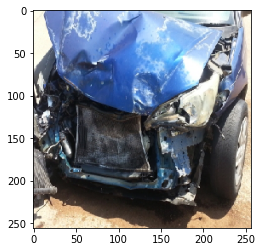

Assessment: Rear damage to vehicle
Location assessment complete.


In [0]:
location_estimator('http://www.sturtevantauto.com/Content/files/CarBodyDamage.jpg', model_final)

Determining location of damage...
[2]


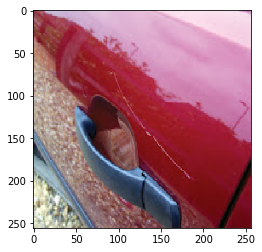

Assessment: Side damage to vehicle
Location assessment complete.


In [0]:
location_estimator('http://1.bp.blogspot.com/-ToQS-qIxYbo/UDNuV5OcVQI/AAAAAAAABdo/tjeQywWiOo0/s200/Key+scratch.jpg', model_final)

Determining location of damage...
[0]


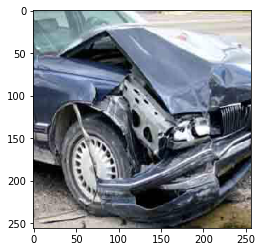

Assessment: Front damage to vehicle
Location assessment complete.


In [0]:
location_estimator('https://www.libertymutual.com/insurance-content/copy/claims/types-of-car-damage/severe-car-damage.jpg?v=2015030112332273', model_final)

Determining location of damage...
[0]


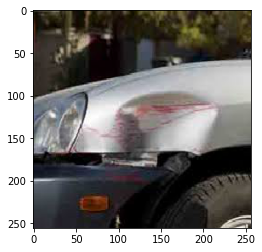

Assessment: Front damage to vehicle
Location assessment complete.


In [0]:
location_estimator('data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUSEhEVFRMWFRcWGBUVFRIVFRUVFRUWFhUVFRUYHSggGBolGxUVITEhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OFxAQGisdHR0tLSstLS0rLS0tLSstLS0tLS0tLS0tKy0tLS0rLSstMC0tLTctLTcrLS03LSstKysrK//AABEIANIA8AMBIgACEQEDEQH/xAAcAAABBQEBAQAAAAAAAAAAAAAEAQIDBQYABwj/xABAEAABAwIEAwUFBAkDBQEAAAABAAIDBBEFEiExQVFhBhMicYEyQpGhsRRSwdEHIzNicoKS4fAVQ1M0VIOy8ZP/xAAZAQADAQEBAAAAAAAAAAAAAAAAAQIDBAX/xAAgEQEBAAIBBQEBAQAAAAAAAAAAAQIREgMTITFBUTJh/9oADAMBAAIRAxEAPwDy0YtMH/tXW6K3disgAy1D+t1QYhFlkIU9FVgEB2yx9xpZq6XtF2hkYf2jrpcWxqWVmUyOcN7fgsxVzgOOXZPgqtNOPVTqkuaKrJcR0CG7RC8l+i7CTrfqmY9L4yLHzSn9Gpr8lrKOrDKa7m6uWTjK0ddLenZffonn5PHxtWQzeO52vtyRVRX8NgqvvLE3CdTvBPiKNUoPmq8zMiDEuUKeMXaXDqq9rrlVIa6osWyxlm6rKqXM64FimsbyStSs8lVthtc1g1FzwU76+S+2hVKeiLp6ssZl31WdwnwL4VbfC5ps4aH8kfHiJIc92wuFkIpTmGvFHV9Y4ENaRYi581GWH6exGI1bXOaRtzXd/wDrA6+iro3HfnvdTyULi0Ecfkr44jbRVIzt01ss5iFSdGclZYMXC7Xa3QtbGGvu4einDKY0wuF05e64TqijFy21nK0w+oZA0kjdBVFUXOzN4/5ZHctu4QWkpC05yLgaW/FWQq2yAANsAg5MRygg8UNhr3G5aCQqm6NrOOsOYgHRNe47FMLhy14ppfco0VOknI4qc1YdYSXAtwTKa1wTwUNZMHnwjZRrfhQDFY80xKjZh4d7yNqmXkdoo2xrpk1NFn/Vp0OFN4uCtP8ASqbu7i2e3zsq4RpMh5lGkiMFiu+wHvDdabH8PeIv2LDcbjdZ/CHBkgcQSONlqpsTis57WF2ml+azviqjDxYK4WuNTwT6mkkyDw5QOa9AwakbKO8czLcaC2vLT4IjH6KNtO8uAtrqQPkjG7qpjt5QYeHhPyXNoSXCzb9AhcQlZezb+fqpsHxt0BByB1jffdbaLLHS2r6MMi9lzPMcbLNRbla/tH2tM8TD3IA4+oWNjl8RPNEifQ7JZt+aQt0SNeSNEzxI4ptSjZK111PTQ57NHFGyYMeB4KccLSuSqlKkZNbdPqqRzUNHA5yNfKqLCaUEDLvxSRVTh4QT5IQQvCIoYXF4UZY68hpMBmZ7TrjzViI4XSXIvfZV0cFtDxSZ8hJuNNtdFxZdPzapc19Gwxnwi9tFiaqNzPdI1WkOLOcBcbIWvqGvFjvZPpbx3sVnpjcahFYbPlboEj4xqmxPvtuurDJIrNmO1lECVHLI5oQQqitNbC0idYFLGwc7fVAwT3N77Ky7+I6kgabaC657Ksyp9opgYnTO8RSMK6027PRGEUQnm7rNYnXl6IV8exvxAstExkUBDzfvXNuwjmBcKcqRcEw4R1RifrlTamB5kkERaG5tuSr2Y1aYyv3IsqybEXB7ix5sfndRxtPcj0oYvFT07SXAuA4c1552q7SyzgtvlZe4A5KmmqSTqSRyuhqt1xdVjhIXO7ApHJSU0la6O/qV73ZQCdOCiaErn3A6Lo90yHwbKRRQbKVCa0GDMGQG2qsnFVuE/s0atOn6Z2q/FRp6KrpxZWeJOB0vw/NBQRdQs8/bSXwaSnQyZTdFHDzbNcW6IuLs3O8Zo2hzeanc1qjYSXEiVHUVVxoVHWUUkbsr22KBkkA4JdvGnyok1xCjNZm1VfLNfgkjNhrdOdCF3JVm191HM+23qh45uQPyTXyXKz4aVLKmfMTxUYCQMcdhfyBP0REdLIdBG4/yut9FUCIabKQUzy1rsps/2eqLjw+QNv3b/wChyJEM4bmyvzDYd28AeQAKvjC5VFK45ipGKN48RXNUmWVl/esjnYo/K0EZiw+Em2wQJcAon1VtkgbVy53ZiLISQoip2JHFVpdommlJTZ/YCSNNnOiooGuuS2SWTaOStXWSs3QQ6FT2T8Ow+WTRkTz/ACkD4nRaGl7GVT/aa2MfvHX1y3Qi1DhvsBFXWhoex2VoD5L/AMLbfNWcXZunaNdf4v7K4h5TjDCH7/5cqKDD5ZD4IpH/AMIdr6r2inoYGezE2/PLco5t/dbb4fRKw5XnPZTs1L/vxyNaeDlrOztNVwZ47ROiJ8JJdmA15eavGxvO9h5KdsJ+8fRTpTI1/ZN87sz5ba6BrSbeqFj/AEcQe/LIfOzFvo6fmT6pRSt4BVE3bIQdgqEbtcepkJ+gR0XZGgB/6Zp6m7vmVqmQ2Tu7TtKRQR9n6Ru1JH/+bPyRkeGxD2adoPPI0fMBWwjUgjULVopR/wAbfgE9kH7gVj3acI0AAIztlHwCf3TuSOESd3SA+b3nU9VzUwlKHKFmznohpoyi4xI9wayJzjvoLq7b2RqprOEYjFh+0db5BIvbJvebWQhcLfgvR4P0dNteeqP8MTb/ADKtaTsnh8YFojK4cZCbfBPSb4eSxMJ0AJ8gT8hdWVL2Zq5dI6aQ+YDfm4hetfbaaAXbHBF5Fjf7qU4t3n7Nxd1Go+a0kLbzmi/RrVusZHRRD9593D0Ctov0c07f21Y5x+7G3h5lbVtNK4eN7hfgDbRSNpWt0vc9Lk/NOY/p3Os1S9jaBtrQPk03kkdr1yjT0VxS4NCweGGNg4WY0H47qybTPOwy+Y1/sVNHh99XXJ6lPU+IttAxtaNr+WtlKM50DbeeqsW0luCkZAUHpXR07veefTQJ4pB5qybTKUU9kxpXti6KdkaKIYPeCY6Vn3wkNGiJPbGmProx7wTPt0f3ktnBWiWyFbWMPvKZs4OxCRiGtUjWqBs4UokCQPypwTA5PQCgJ4UeZODktg8J6jDk7MjYeJUPYpx8U83dj7oAJ+PBXNJg1HCQcneOHGQ+E+g/FNdO87lObY7q+Gk81lHXhotHG1g5NAaPko/tDzxt6oaM5jYa8BySTuLCQdCPwVzGUrU0kxGwuVXzte+4c51uTL/MjVFQkv2FyrahiYAWkhry06nh0RdY+BN1l34V0aPIa/HdS/o7heKqpgOwaHgcBdzhYDgjW05z6nRWP6LKPvJ62cjQvbG0+V3H6pZePIx8tM3Dyd7+iJioABoLenzV22kUv2dTyVpStok/7Grn7OEyYNYMxOg19EtjiqhSoOrrYotyCeQIQ2KV8sl+6HgOxHFUMuETHV3HqlclTEXWdo/uNVVNjkruJt0JUNTShlwTqhgRzWXJrj0cr5PfWyHifiUzv38/mUPO4jUMzDmCmfaNv1Tvii2r7WX4LF+vzUjSevzQQrG8QB1LtEVHL90s1/eJ/BGh2svsEsc62iIhneOPzQ7WSW0DD5d5+CmjopXa3aLcoz9cyNUrhR8GIEbqwgrroCnwN7hczgf+P8yQposFAOtTfya0/RaSo7f5VxFUKfvVW08GXQZ39S23qEyaqcw2IPS6abhpa96nNlVG7EzwCT/U3cgpqKvw7opAVmziL+ab9td95IMfNMAbAEk7ABE0lH4vHq7fLfQeZHHooIxk1/3XaH93yWhho7MtbUi910Z5T4iRc0OG008RYXhj26721WSxOnIJaSDYkA9AU10TrnW3VG0EQac7jcRjPrsT7oPS6nG+xl8IJmUwLLEyloLiNm5vdHVV1RiRe8ua0t0HU6clKYjKC43JLiSeHQK77M4ZGHOdJwGl77rLLzfLSePSnmkcKd8rhY5SPW5W9/RnhJhw+LMLPkJldz8ZJaD6KoxzCGyMgpgdZ5xc8oWDNIfoPVehQPbYBuwAAHQCwCvd0WjhEmuskfKhZJUgkklAWU7V4lplANrb8PJXFVNYLIYw5pJdq7oDohp0v60rIe0pjFsp8haw+KU9rC82IsPmqLEHgk+EtPIqocXA6OaPNLSrPLX1MjHkkeLrwCHbSDf5IDBpnG4vp6K1ueaz4xretdaQujv7g+JUL8Nadctv5j9EYSnAke7m6BVJGePVvwFFhbTxIPSytqSla33vjb8Ao2QyE+yGDncE/BW9JR7X1KrUGXUyv06mcPcufoj4aZ7v3R0sfqiaWl6BWcMA5Jsd1X0+ER7ltzzJd9L2R0VI1uzbeVkSAmSvsjR3K36QEC91isfnb3vh2HU7q9xbEcjTz2WImlu4nqgtjBIkMqG7xJ3imkJ7xcXobvFzpUgrMEhL5C8hamaM6AeXxQ/Z3DrtHUhXVRExj3OvowW/m5LXe0RV1MIb4BwAv58VXYxdsIDdMztfRWpcO7c9+jnm46dVXY+9r6duU2AdqeZSlWq4HOta+hWuwGLNIGjTKBrzI4fNYymlDdM3r8FrZMQdBBkb/wBVUeBg+41wu+Q+TbooGw1eeqkmBGWK0EX8DT+uI53e238qvPtGbXM4HnoVk6Voa1rGg5WANbffQWLvMm7vVX9IbhJexzKl43II8rFTSS6XQ7HWUdRSNcLm9/MhB7lDV9Rwb8tx/dZuuza6k6e9ZXFRSNHskj1WdxUWvdziPNCsdfGbrX28O1rqscebxdE4jLbYG3VVcdr3IFuu6BfaypKvuzcOBCtY8RDtna+V1mXHfXTlYKxw4IRtfwhzt3G3IABW1FRjRB0UeyvqNmiE3K1NDDZH00aHYxG0zUENjjRUagYVJ3iAke6wVXX1NgipptFncWqdEBUYtVZiQqgKWpfc7qIKaD2p1lFdOa4pA4vTO8SOeP8AAonyDr8EaC6oq/I0Ft/XyUDu0HhLHNuM1ydAST1O688j7azHhGL8DlsPRU+M41LUOa0kNAN7sGW3wW3KFp7bG5oLWvGZxZcjYN3t8rKtqqEvBDdb3NhsCV5fB2mqGeEzuNhbNd2Yjqb6pXdtKpu0hy/h/wDFlfFVJPtejYfhdpf14yMjs43sLganVPfWd451W7RrzkaXf7cN7Dyz7eS8rrO11RICC/RwseJIPDVQM7VVTW5Gzuy2sb2JI5a8Oicu17xk/Xugvw10Hwtor/D4HL5sh7VVbfZqZB0B09LIlnbjERtWSj+Ypp1P19N/ZzyK4xOsdF82M/SJif8A3sv9X5rSYD22q5o5TJU1Jc0CwY5viPIm3hQWnqOIOIvcHis9XPve4WCqMcrifFNPv95xIPI6IKfEKr35ZreqCku11imhJtccFTh90I+qeQbveRzJIsupHBoJc4k9SShVyWAhedgLeat8IgceXxVRRTRuIDnhoO5JWvp6OiDcokGYj2g4/gUJWMLbAag+RCucMeCLuIbbmWrGSYfHezHZvJ5/NeedosYk718YAaGOc3zsbJSnY+hnVMX/ACN/qb+a5uJxDTvG/wBTfzXzHDNK82BJ9SrKiwl7j43nnYE6pk+k24lGdpWf1t/NTvmtxFue/wBF8zSwgGwZt11VlgeOOguHSva7Np4jYehNiEB7xNXtN9bW56X8ll8UrQToQR05LFH9Kclix8TJWge37J/p2WVxTtdPITlORp2Dd7eYSqtx6JJWRs1dI0Dz1Cq6ntbTM0Di49Nl5jNO5xu5xcepJ+qjS0VrfT9vGD2YifMhAT9uJD7MYCyN0ieiaSTthOdrBQO7U1B9/wCX91RJbpgcKH95OjpiL3cpbFKG33WnGJ2SOEX1IsnikBPtaXSCLopoouiOMGyOwxhHt/IKKTB228L/ABddkSQORSZeSOMGw8fZ+V2xZ/V/ZG0XZGd2r2i3IPZr800MPL6qaO420VcINlq+zc4NmQ5R94kEo3CaR1KHG5c5w1FtAoWVEn33fFP79/3krhC52rGDGXB2aSIP09k7HzUlFicYDQYXg63yOGWxOuhVV3pSOkPNTcY19fGhlr6Z1w7vgOVo/wAURRVWH5g17yAds8bfm4LIOP8Al0hkHHX1S4/6Xm/HoMM+FN1a+O/7xNh8kXX9oKJpDWtilbbcWFivLXvvwH1UZYOXoNE+BW8b5ekPxuiJDTEGaZgWuHA3t56LyStYZJnuDSA57j5Au5qwfGPx3Sd0AP7pcNDlsfh+HhrdBfmd0TA0MOYG9/gqiKqLT+re4O+XwRUuI6DvLXPFo38wlQJxMAuGlid7fgqXGLBgBADs2nO1uKmrcTaNhd+np/gVJJKXG5NyeaQMXLlyA5cnAX2UjaZx2aUBClRrMMkJtlP+cPNEOwCYWzNy3NrnYHgClsKpIrio7OzstmZvtYi3xUdRgM7CA5lrmw1BuSCbfAFGw9SbgWEgasqD/wCRq7/SMJG0NT6yNVUZU0yLZA6agw0exBMT1kagJIKYbREfzpO8Q1RIgEkEHCM/G6Gc6L/jcoJXqF7kqBHeM4N+O6hfO3koS4JhKNhOakcAk+0A8LIa/wDlimuKNnBX2kfdXOqQhLpqmtMcsp6FOnFlB3wTLppUq7maX7Q3kudKEHPMAgZqgu8uSe6nLKZe4PmrgNOKgZKXndB3T2k7DQo3UaFGpy6DdQySkbm5PySO8I/eKHKRuLkiUC6sKKgzEF17chuUAFDEXGzRc9FbUnZ97vaswD725VnQDIC1t9dLO2t5ohkga4ZhlJFgW7EXOnnup2cMo8JY3ZrXH+Lb+XcoueZsRBcy8btNtWu4ehKbUROJD2aPaLXNruaPdPRThoe0Xbqd1Nqk8zczSLCxHDfprwtdDw5zG5kjjdoya8Rwf52U0QDAGg/2UiWwFEJdF3bySbWzEnjsUskedmU6OFiHcczfZKK7tSBoAQAfeLjKg+8XGRdDEUZULVSJM6FqJEDRr3KNzk0vKaXIVE0EBeTYgWF9SnCJv3/kU/D3m0gB93bTXyUUjncviuHrdTLlr09Do9Lp9vl7oqnoI3j9qfgD9UkmGt919x1H5IenlLeAUzJSddlj3M56redPp/gGojyuLb30B+KjS17/ANYTv4W/FKLZbld3Tts8vPzxkyujHfLmgKmq4D4ptZVX0GyEurZ7cSkXJzAhJ2VTkZRc78EkI4nYKKeXMb/BAMc66QBPjjJRlPDbW1zwQCUsNtDurGncS6zXeLjppboUNkubA+ZUr5LAAaWQFkISBdriX8jqHdEVCyORhDr76tIIyusPZVDDVOBzXVzh2INe7xCx5nip0raxgjIABNwBofzUxIHmue+2yhKimdfdMMyjfOAg5KhGgOFQukqOqr3VAQ/2rVGgnuuzKO64FdDPSTvEJNJqppDog3oEhSUl0iVBkzkHQkeRITzK77x+N/kVCUpCzyxlu9KxzuPpJnd98+gamSPd993xt8gmZyk3R28J8O9TO/SRj/6pTSyPa4sFwwXOl9uaGqpMrd9T9FoOx08ccFS6YHK9hZnvfLmFr5UZXUKVjXlNT5QATY3F9DzCYmVcpWNUYU7COKCdM6wsoWMJIA4pTqUXTR5ddyUA+KPL6b9TwUoJ/mPwH5JGtHPbfz6JWO3J4/ggFaMuo+eybdK838kwBAOv0Std15cevBImu4DiSEqcarv7AcdAmum6/NCucbBJYn/CfkFnVFkkuhnb6jU7DiVtuzvYKSYCSfNFGdQ0D9a4c2h2jeGp5raU2ExUotCIqfm8gS1B6536NPk1Gw8oouy1bOA6KkmLeeQtafVwRp/R1iP/AG4B5GSJp/8AZbfEKile79bPUVJ5d7I4HpkjAaq+roMNa1sktLIxryQ15ztuW+0NTe45Jh50lauXLdBsqFK5cgES8Fy5ARpz9kq5T9CFOauXJ0AsR3HkrSgFqOYjfTXiuXLPP0qM+Ui5cqKlClOy5cgjIt1YR8PRcuQCHY/xKYnQLlyAjalXLkByb7zfNcuSpxeybLQdgow6siDgCNTqAdQNCuXLOqexVO1+N3/KyyULA+fK8B4vs7xD4FKuSD0yioomM8ETGae61reHQLxv9MB/UU54/aaj6NXLlVJ//9k=', model_final)

Determining location of damage...
[1]


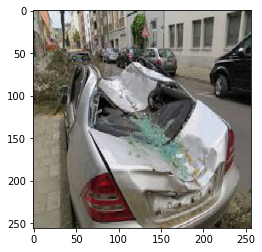

Assessment: Rear damage to vehicle
Location assessment complete.


In [0]:
location_estimator('data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUSExMWFhUXFxoXFxcWFxcaGhgZHhcXGhgXIBcYHSgiGB0lHhgaIjEiJSktLi4uFx8zODMtNygtLisBCgoKDg0OGhAQGy0lHSUtLS0tLS0tLS0tLS0tLS0tLS0tLS0vLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIAMIBAwMBIgACEQEDEQH/xAAbAAACAgMBAAAAAAAAAAAAAAAFBgMEAAECB//EAEIQAAEDAgMFBQUFBwIGAwAAAAECAxEAIQQSMQVBUWFxBhMigZEyobHB0SNCUuHwBxRicpKy8YKiFSQzQ3PCJVPS/8QAGQEAAwEBAQAAAAAAAAAAAAAAAAECAwQF/8QAJxEBAQACAgIBAgYDAAAAAAAAAAECESExAxJBUaEEIjJCYYFScfD/2gAMAwEAAhEDEQA/ALuPSk5VjepIVxBEyDwO7zFFsLiAqeKTlUOB+hEHzqpttrwFQtBCjzgg+tqAYTErQ+XASUkQ5wKQYCtdRE6bjxrm82O46Pw+freenovZbEeBbJN21HL/ACKJI9DmHSKL4nDJcSUK0UIOh84UCPUUp7HVL4WIAAsrrqnoQfUU2BddPhvtjK5/NPXOx5h+y/Bp/f8AFgknuUFpAVeEd6be7316BtTZ0tKbQAAowoboiCANALC2kTXn+wHjhdq40BGcqmwmcql57RpqimvAbcceUhtxrIClRJ4xlk5TcC8delO5ami1vl12n2GhbCUp8CUrSpSUgAKE6HfEmar9kcQkOuoTbKAL7zm8QjfYn9CjuJWFMEpuMtvL/FK3Z9YRi1BN1lKiRx0Uelgax/c1x/TVnbuVay64kJzMqQJMwc7qBf8AFpu30pf8M/dmywlVpzkAnU8zrcHlypo7YbNMtBBkqW6qTbLJQRSRsXHOYheJDypKFeHdbxACOWvWnkmLWMSXHHFIgjWQbaTHWAfSjj7QTkXO9tQ5AqSTAFhu676AYTEhkKz2zAEX4pcHzq07tXMhLeWIbQConeEoNh1HHfUZdLx7GmTDqv8AwrF+IIP0reyH0pbfCVBZBUqEmZBUtSQFeyZ5G1DNtqzLWkgarA8ilU3m9qsdn0FAcCgU5keHNbNEm062p43nRWbm0imsU77S04dH4W4W5HNxQhPkPOgqcfh2nCG2y4UmFOrJWSq1goyRru9KK9q9rdyypIMLUhUE6ARBPv0pDbxakp8QJgpPtKzKWDY28MXm3rS8ud6xYZX6HfA7YS4+jdJUEjeBltO/UGmKa802Till7vDuKTEmRNo1M9YEgU09p33QhJbUBlufCCbwNT5e+q8VuuVTet0fQ6k6EHpXeEP2p/k/9qX+yD6ls5lklROpo1s7EoW4rKoGEge+fmPWtN8HBSaw0v4/taw24pqHFOJ1SlGnmYEXqltTtcptxLSGJKkpUCpcC6c0GBqKRmyuTQrs/tNb7IdWEpJUQAmYgW376o9tX3UsS04pCs2qTFoMikZiKqqYrarLZhbraTwKhPprXlbLLzqkd46pRKk+0pRsTfWiHbDAhWKKxqTHkBQR3a7UYVa0toczqUYASlUT1IiiuavNey+zoxTSuBJ/2qr0cUCK22cSptlxaIzBMpnSd1eYYntjjFEhThSeCEpHvr0fbyvslDjArzJTIKlK4qPxNEFQNYx55xKVrcVmUkeJR3qApl7f4bMpMfcTb5fKqnZ/Cg4hrkqfQE/KiXa5Uk8yB6X+VHyRIThlR+daoxlrKZGfZW3lqZHfwoTkKh7QVnUiCN/s6/GrmBYAK5+8hUTyNh5g0vbKSe53CRmPMzmnrIq4naRQLEkoUpUbykrkJm+qSBWWXM01x7GOzr6vG1AIgjW4EK3bxMeRqZ5SM5ylWaYygnLCilQ0PBQ99CcYo+F1h0NKPtCQZueUEaVLhnVOLjwZjEKuBFwBYjeU+XOlLxxV+Tx2XlFg1KRtBaxOY4cKuYuFNpud48JPupq2YUlDTwvnaMrOhvJgfclRHpSR2gacbxKwhQzDDEmwPhzKzJI3GKvdidpheG7pQnu1FOsAoMrjkZUfdTy32id6GD2oyvZRZBGRSVT4ZJlQ53N9/LdrCKyYtLmYJUZgSLjIQbb+tJ23GC1vStJWdDZPhBFwbmJ91HXHMrzGIkR4FC4TmGaYubkj41OMyl5PHjgydoHYU5kbJOdtQEHRbXLgWx60rY1DKYDWVK1JJdy/ikWJ4yTaaK7c28HlZQn7OG16G47xSZvG9ahEbk0AQP8AmBC1KSoLJSRZM6dfTSttbTNaV8QQ6pARchCUn+ogf3D1ohg2JSlUCSmPESRYZfZTB3fioZs9YRiXJk5ec/fBGug8Iqba+OeYS2W8uQr8UpkgFZNrxoanQ5MORZlSnHOJynLukwU+LdpNVdl4loueBtUqSrxlBH3VG6lX5edaZdc/fVtlZLYb9kgQCYgzF7BW+i7DYn1+FMi7+0Rkqw4WBOXxeVpNIrWJMCQcpRZIMTFiZFgBlTrz4mvSO0QzYfq2fgDXnL+GyhGcGAkyOAiTy0pZzlnYbezjTTbRKlAFcZ4BPh8M3CeG/dk50dS8O7kpCglJEKSoBUaGDBg2NecbKlXeAKISUAgXIHiRFjyp3OLDTAKzuKbm5148hNGPDbLyTLHWvuYMARcJSlIEQEJCRx0FWMAlKXFJSkJ8CTYAC6ljdvt8KG7DxPeJUqIvEX3W3gVfwp+2X/40f3OVd6RIU9vqSjFKURcgi3X8q77QryutqifCP7Ej51H2pR9v5D+5Vd9rLLRH4T/6j5UiMvZZIGGTHFWn8xHyqHtgfsD0V8I+dTdmExhWx1/vVVftcfsT+t4oUW9lp+1bH8afiKm2+ft/JR9SPpUHZ9r/AJhsx96fQGs7RLAfv+EfE0fKfgS7LAF8ckk/L504Updi0ArWq1kx6n8qbKKcC+0S4aPKT7q84adERvp97WKhlXSPW1JDOENrD3U4VG+xwzPk/hSo/AfWuO0QKnAALXUo6BPAkmwrjB7RTgkqLg+0WAENiM0STKvwC4ub8jS9i8Q5ilFTqiEA2Qmyec8epvRordRYXtLCgwXiSNcqCR5HfWVXbaQBA05RWVWoj2GOzypSU8FRu33+ZqxjmAmTJSSlQv8AjCUlNxySast4CFfZpgm5lU8b8Ab1bewAnMoSQNNRvv8AG+mtY3tvLdaCBsxUTMymR7IFhc9fzqo9jMihaSCZIIkn8SbQDpRDaroCAZIOmXhY/rWL0vuAwQAZ0uRPv141n6yLy8ud4tHG9puuPB+UqtkMi4QQU5Snd7xJ30bw2OwxzoleYG6UgJylSRMAAzSbgF3gzmEwZ36btP1rXTOKVC0gZc5IKxpA3m8gxw46VckvbOXXRk2q/himFCNT4l5SbEHRudD7qHYzabDoQkYhkJbkiVyQLmJCQIAtpuqng1rEkgpGlpUCR966jHrN71SxTLi3vCQoeEDMVJCTJvAGhte/OrmOP/UTO/QaYfUXGwFIWhaClK0AiPGFiRcap4621NXnsUllzISCYklUgKVuBCQVCAeAFLGzAtJKFZUgnwgTZRvrunfwsd1T4tBXci033E6zJ6/nSt0f8jOAQh37QJV3ioKykpyZc0pTmWRcibjQm9G8Tgmnm8g7tKrlSSrMEnw5LzB9aRcMVsoSkh43XJBCgkDLE301gDnU+ze3fdILbiSsi5IseV8w5WrXGzSb2OK2g80vvcQlISJSTnamYMAQq5iLRWY/a5BUmVhUDLeE5tYCR7fDfF/JW2t2jViQO7JS1MEK9oq1JIzG0RHnQhK3SFaqhJJI+6BEqPK4HnSpR6DiU99hCt0rQ6JyohQTKZAGUAxIHHeOlKz76Vj2iQRAlRMApuLjmRapdkOO4pkYdgZlpsRCBIm4zqA4gxJN+FS4vs1j8OnO7h1ZIJUpQBbRc2OUmbQb2vT7PKSW+t4R9n8CUkkCRAuVEjW/3QRECwB11FqYcVtQAhtTTDmWSoFtZ3cA5YAa6kzSxhsanMGXU5MwkLbOUKtoRE8rERwiraxhdXW1FJsFhZykxpIjKeSik8qUiD1jMej93Q6yhDUqSHLlSUyFCbncoBPmKEsbYWXBkX7XhUSiDaYHiFxfdxNVGduYNtH7uppS2loKVJKiIAIMg6kyJBnUCrDzOEaypb7w3OQZs145jgN9F54XcMpJfquPCHAHshKrJWU6ciJEa6/5BLFbPKlZiEHcJSTA/qpQeCiJcS5vElXhibWHwpg2Fj+8bn8JKNdYiD76mjHeuTBhWylCU2sNwgelVdpMKXbwkcFA/I1x3nOojiDxPrSNvC4EpVOVsR+FJnSNZrlWDXOaGyTyV9a6TiD+I+tbGIVxNAWcA0UySEifwz86t5qHoxCpgSeQEn0pf23t5wApS8wzzdWAr+kCRTktGxnbDwTdSmwkfjJEHrSXtTtctw91g0yr8YCj/SkifM+7WgO0EtOHM7tFC1cm3lgcYhIAqF13DZAEvgkbxhRfyUoCqk0VqxsXH4Zh0u4ppeIVHsFZSCqbqURr06zXW29qJcTOFaDSVKuhsqOQRcSq9z8aCYotKHtOEjgw2geqXDVZpYG9Q6RTSvMtPBIu6OQKh8qyq/7yOL39af8A81lMPUdnuhJCVISeBXlsJ460Sxb8AlBBWbjNIETuPTypVdX482Y5Z8Wog38Frbt5rHcTlVknNN0wfTT0nfXNtozEYJ0rKiIgyTIAve9404VWebUJBSPDqUHSw61KMWYEkiTIjNPx+ddqekKCog3ki/S8kUgrMhKlZIzZpndYC5tOtvTlUKFZRcTuA0m954Cp1NJghFir73T5fnW3ZlUmQJMkapF9d/A660z2oP7UCVJRAASMy1WBNoSLgx0g+6aN7FWl9KipItGUkAgAqAslcjfOnzlFS2p5xSj7OaTzvYfrcDTjhVFhhbigQCPDIiUpBUSOIzZL8a2k+EbM3Z7CoxuHWWhlWiJAgpUkiQrKZSTZW6LGwJtWc2UohagIebGZSU3S4if+ojNppdJvu6uf7MtgqwWCRnT9s741A/8AbSZKUTxAN+ZIqp2qdGGfacyGFFQyovqNAOpFunCncdwbKGDeBMkzABk24+W6p3FpKgCBc7xyNWDsN8DMGpQs5gkKBUm8hJQSLxFkyKt4PYpzDO2+CbgBswIERImNdSOFTMaey/tXYSHilWYpKYIAykEiYlKgZ1PrWbL7EueJ5w940UqTkShKFK0mCOGlhOsEEU8udnMqQch6kknXQx4QNKkS7HhkyLW+FX6p2X2XMgDYaCEAQlCUgFP8STGvWZvNFcN2ndQChUKTEZynxAaAHxe4n1q0tcGN9Uf3NKiSeNPRM2l2MwOPR3iQWnEmczJAEnihQIv086Xh+zzFNrzMqS6j7yT9mpSeEHMk+ZoshCkLJQooUNCkx7v8UZY21iGxdAdBvKLH+n6CmHke3tjvYYytlbaSYKFpOWf4VjwkHiD1qn/xRSwCm5G6YI3fo17ae2eGIyvFTc2IWmB6EXoNtHsJgMWC4w822uZzNFAEnigWv5GiyDfw8mXtJzeoebg+tPHY1ahhwox41FQFrDT3kE0L2/8AsxxCDmBQ6BqprUjj3Z39Ca72fh3GgEhZAFsqrgeW6ss4vE2lzp6VB3Qm5V7vjFCUYl0akK8o+ldpxyh7ST5H8vnWfKhiBzFaCeCvd+dCUbQRNyR1SPkZqwjGoP3/AFMfGjkcKXaLbi2UlpBHeLEZhPhE7tCFH4TSGvFYVBPeNqeXwDhQ2ON0+JZ8wOutSdqkEYp28gkKF9xSDuqnsfZS3fEEpKZI8UgEhOYiRpbfWs6RWl9y6Ps0Ftf4cxUD0zXHrVCPdRDaOz0gd43IGsHdVJSpvxpkjCuZrYX+orst8x61rJ09RQGsw5+grK3k5e8VlAerNpQ+QPs0yVaGZMQmRANvKqa8MwgLQ4rNAk7lTockRO8xeRv4r6cXqRaNyRvnhuF91Q/vEGTc8zMVg0FMfjEFwBsqSgaWMWgiQd/Od44VjQBkKMRqqZNyI95H1FzQ040KkkDhprygVIxiM3sgKEHMJFxu9IHSKNJvLtzGNp0zrvrmSgGP4cq7edb2m8EsriRYQIiMwBgQd0AeVUdo4lpBgIJypk+JNiToPBfXWr3bBgIbSANSOvilQHlEVrJC5C9kH7MdSo9dPcB76duzuD7xbXeDMhoJWoKuCqc6UdAcltIQRSnsXCg5EqMC5PQAqPrAH+qvQ9ht5UCdVkrV56D0q52R82I53mZS1WHiVOm+TO4Ukds9rDv28S5l7uSG0EwQlJEbrE+JRnSwtE0Tx20i2wWkzmc1IGiBM68TA6ZqQMc+tYW+QEtoS4fCASoAGATzED/UTvqrJrkt8vRNkY8LSFtqkHjqORG6P1amPCY0SnNII11KeG/SvCez3aQIX4FBJP3YgEcI09K9T7P7VbxKfAYUmM7ZPiSfmDuOlKUHfEvJ7skqTG8zbpc6xxpax2FJUVt5jvBiQRxzVfbe7sSBJG47+W+uGcdDGctKSoFSikmCAVEkjKSSAD50GBLby6686ios8Q4nOmDPHXraqC2spvTJUcEmpO/DaZUoJA3kwB510pIrzvtLtVbhdXlUWmzCRMAXKc38Vwek8BSt0Gu2e1+/dGRQKGxCRJhRJBWdOAgdOdDkY5kgBIKCJlQObMSZkpJGmlj1ml/OtSC4IicoAIKpiZI3J58aH98pJsaVBuxhcUsFtxK8wBUo/ZFK4MgDNBTz9worszFvps61NyFeLNn/AIgZ8O+49CLUjM7TI1ophdskaKI/XCg3oCW0qTnbMp3g+0nqPn8DaoiIpawPaJSSDKpG8Jk8CDIuDwpqwOKaxIlogOD2m7ieaZ/t9JqdKlV18xPUVCptHCOlqIoUB7SJvF8wvwtXDikH7uXySr+4VOj2XdobHbcObOUqiJN642SlAw3dKXlSpKZOhSpWZIM31J91F8RhJ9l0p6IA/tNAdoHENslkNpWm8OJHignNB32MxrE1UKhTrgylMyOfnQfDJBTqBHEHjyqZYc/ArzEfGoVvL0M00pe64EHzj4xXJZVwPpb1qsp41oPGgJoFZXH72v8AEr+o/WsoI6O7PIHta6gCL/P0rlOBItlA0Oo986UfOzlKUYGUWEEX9fKuk7GXBAH5/Gua7baLj7GWZiTeIGs9I41oOhAKtPLUibx1v50xL2Qq8gFUTAP1/Koh2ZccOZzwgWSmdeJMaTS9h60qs4IKczSoibwN0+vu+FN3/DRily5uTYX9pKYSfIe81XxGzENKSFkQrNEEeFSU+EmLQT86K9nHPGgnSfoDW2GW5tFmuAJGG+2IGnhT5kBSv9oprwLpKgAaEmAso3olKuoJSPclX9VFtiJldaRNWNpOI/eA2qCe7bASd4LhKvcoUidomGmcG6ULXmX3bJSoAAEkOKgjUHIfKmLbTv8A8iTbwJVr/Cwk/KlzaWIbaabUtgOqUS4c3s6lKTv0AOo+8eFVl2UIrLClGEpJOtqYNi7UdaWkrzIUj2HCDI5K/Gmo3ziS4XS0SVR7CVQAAABAHAUfwallALiQk8Dr5ikZ47N9u23QlD57tzQKP/TX0cmL8DTq09Mc+B1514y222J8AvrAubRFrnpUeF27iWSSx3ga0hwOwk2uCAQOEEdNactg4et4wIaUHMyktn20pTMqvBH4bxNWcIEONkkifwzcE6Twrz7A9tsVkOZvMI8Sy2rLwtp6kVawu0lLRmYdLaVHxpbSgGbyfZJHruqd6o4M20G0NhSicoTdROgFeQY/aqAX0CQhSlqTmiJJClIva97eV7S2Y5hToKVuvOEQUDNnTYmRJVIVBB0NLOP2OlxKSoFJkiLGIiYAMHUX16aUWiaLqcEhVwqfCngI8IjqPpUyNkSPEfFNiBcp5j50Uw2AbbkhPi3EjMSeuiRUzaI5qNOBVRsVlOoJPEmp1MNoFkjpF62+7Fhr8KgaaKjO4ak1RJGzaYjhXWFUoOQi1iSd0pgxwJiedxXGIegFRp8/ZV2cCyrErhSZEGAQpQgwP5TY8xQD5sfZxGGQ2/C1KErzJ1J0kcQIHlS9tvskRKsPcf8A1nUdDv6G/WnlyoKqSWFvTyFaCCQRBGoOo5RXBFen7W2K0/7QhW5abK8+I60lbX7POsmfbTxGvpWeWFiplsAcZB1Aqo9sptWqRRGuTUqL2J7MtnSR0oViOyyh7KvUU6xWiKBp56rs+9wFZXoGQcKyjY0ZQOVdFJi1Y4vjUa3tAN53CflWFW7v/k1rEhSQVToCazMD6+/dXGMwxKFbvCTc8qCLDj2ZxtKoIKimOZSQD6xXWxnVJU5OXu0A5VTcnxFZP4Y0ihW1SAmdQCk+QUCauYZlJASgAAqLi4JiEnKhN+JBP+nnWk7IUSkrK3Tq4oqjQxaPhpzNGezzcqocymABV/Y7+VzrWkTVHbuBP7ziDoTO64BjxCeQ9TS1icU2pSAmSlDSG9Pwi9lDiTXreLdQ46hDyEFKxLJIBlSRK0X0UIzCNRP4aCbW7A4dZUWyplRMykApJ/lN/QirRoms4xA3ZvLT0vVPEFEyhdjeFAyDvuAZFGMf2Fxbd2yh4cjkX/Sq3+6gz+HxDRhxpaeOZBKf67pPkaD07Q8jiPhV1gAgwfQ/EUJS4g6p80mPdUjbLZ0XHWKmw4L4XFLbkBKSnh8+VEMIGVTlQhKl+0IiQRGo1oGnAqkFLkJmJmRu8t/lNXWMAqxS8k6aiPQzrbTnQzzkGhg0JBhIvx5cqobSYypgEJBMkneom0m8aj1NWsE4QYN4JEXg6399WXGgrdPA6b9R+uNNhMrjlyVcbs9wAQJ4xeOOmgoc22SoNjUkAk21tFOYbzSC2b7ssZuNovpPChW01hpIUhOUEEZgBlF9BwP1mltvM98KmKQwyAhKCp2ATnvE6iB8OV+Ydxz0rHAZJ9T1qfYey1Yt0Nj/AKYIzqnLIJIieo6n3hb00kF+yvZVWMcbWSUoBz2A9ncozqTuHQ8a9pweHS2hKEDKlIgCqOw8EzhmUttgIQkAX4xx30QS+k/eHrVQNuKqOunK5FaRFaitONhQgiRzruspkTe0mwQgFyCUC6lpHiRzUke2j+IeIb51pRxDRQopMdRoRuIPCvUO0eKDTJB1X4Y5bxXh+H2k53iELMpyhAtpAhPwA86yz038eGWW9fA5NZUc1sGoJ1FZXM1ugGTu76ViheNKlCq4Ld5msVIzqLixmoMbiFFCgDqCJA5c6n7vxR1P69a4xSAEqsNDz3UAibVEtrH8J+FFNgo+yz65og8gJ/uUqqGObOUxB1HuozsljIw0g6hCZ6kSfeauJXSa5SuDNbNcGqgpwwjYxTBZKihRhTaxq24m6Fjod28SKsdntrl9CkuJCH2Vd2+3+BY3jihQ8STwPKlnYeOyKAmr/a0LYWja2HSVFADeLbH/AHWpsr+ZO49N01rEmspqFbNWtmON4hpDzS8zbiQpJjdwI3EaEbiDXTzJT040yL2K2Iwo5lMoKpnNlg+ovUGK2O2bpSLaSExpHC1MRbqBbXKloiQ4wMxaKT1KCE9QRb0qo5sEycqVJ4HMD8fFoSLWinB1KVSkQTHCoA0RYptum8dKjmJ19CaMMpIgzPT4T5elSYfGqPhAObfmQpJFuBEk9KaVtA2UAk7imbgbtPdXDuC4QR+t4p7RliFtumBJ5QbxwF+nu0qpjMawlAznMAIKDeDyTm5W00NEndnIT4koIVeSnW9zffVFSEhQOSSfvQJtxVqfPTzps/00uNbPOKILaO7bzARJCli14JgDQSDvNOWy+5ZQEAABAAECLjeTv8relVXG0nTQWOUmOl7eW6pk4KRqY3Cfr+r0ZY6m1Ty23Q47iFLEyaibfUKoNuqaEJSTOl9T5/KiQHHWljl7OhPh8e4D7VuFMTDgUJpTcQZEV1hNrrQrKeMVcpG8CalskTqdwpZf2+4lRCQkgfGjmAx6HUBwdCDuI1H640rkcha7bLOVKjqDPlFeMteJxPWffXrf7QH4aWrgD8DXmGzUJASEiVm6j+FP1j41nm6vw+5LRsitRXcVqhg4rK6isoBqMiuJJGsV2uSIiuTPIVipwob5qnix4SeVW25JMmaixSAEqMbib9KYKDqZo+o0CxG+jWaaeJOl1wVV0o1A5pVwq3nhQIp27O49K0lCwFJUClQOhSRBFI3KrWAxxbMVcSvbFxx2Pjzg3Vf8k+rMys6IUo2M8D7KuYCrCa9SWARBrzXtPh04/C90oDvE+JpR/FF0k8FadYqx+zPtiFsHC4mQ/h/ASqZUgWSTN8w9k9Ad9VuEc3W8piozUp2vhjqseddIxGGVosetGxpQ7gAyEiTqapPYCV5sxtu/P9aUcxK8Oj2lx5mh7u1sENXR6mldDSi4x+jWg2NAI+FSu7VwJ/78ef5VSxe1sKhJWnEBWUTl1Ueg3mluHpI6xQzGYONx6j9XophtqNOAFK0EESBMH+k3FSOKEXgDnEa+6jtOWEvZdYSEqOYSCN+kxbTppRfZe1lthKO7SRukxE8xr08qrY3DIUlSLFM3iDfy31WwWGc0JzJFgYlXn5H3VO7Kz9PVdxhLxudfECnTdplGkb63gXCZCgbaE7xf6VYwG0FIIgBQOpIgkTrJv68av4zAIhSwrLvv7PS1Fxnt7Thp48uLFB0qEKSmU+pqp3uZSykD2RqNDIv1ojs0gnJMz6AcZqtiUN99lZlWYQTusZkenT31Uylm5VWWdqjbUmmbZLQS1wkz7hQk4cpUARrQPtBt/vCpho/ZtghShvI1FF4g7R/tB2g242WmlpWoqSkhJnfypOwUBQaRfe4ob4vE8J98VxtaQhpCZzESY4kXH+6j2wdiltBKh41a8hrl67z0HCs7d104318fKI1qpsSwUnlUUVTByaytxWUA0TUS3BXECaxQrJThL2WbanlwFV8ViiQRYCDzqdSap4tNj0PwoBcxQ1vreiuGclKTyFBcabnruq7sdyUETdJPobj4+6nCElKqJZreequMxGUQLk6fWmNbR47HIbEqMfH0oIe0airwJHVX0H1qjtck6yTNUmQAJNO5cOvxfh8d/mFsTt3EKBl1XRJyj/bVHC7QW26nEJkrSfECfaSfaBO+R74rlWKEQEe+q6nLzFTjlXR5fD4rjqWf1HreExLbiEuJMpUAQeRonh3UjSvMeyW1ciu4UfAq7fJW9Pnr1njTg3io31e3mXGy6p4wJQ8IVBUOO8VI7sBk6oFKGFx8EEKps2ZtgLACiJ4zVJVH+yzB3RQzE9km9xpuecAElQjrVBeISdFD1paGyk52PG5UVUf7KFInPNOinRxqjtBdrUvWHst7MbbaVIDgUfayueFR0uhSSPSKPt4oBMkEp3lIJ+FxQLFtEGeNRsbQW2ZSaJdCzZhZGaCg5065gROvDWrG0mlhMrd8I1BMKy74vc6HyoLs/ajIcJdZTDliRa+6Tw3daNL2XhSqUhFgCCcsidR7vfVbliMcJjWYLCqcTlaIySJVJMgaJkazYn0o9g8CG76qNieXAcBypewgOHXKFpKFKlQKhI5idelHcRtAFJI8KQJKjYkdN3xow1JrSst27BO1e3BlU03rBCl/htonnz3ddEPCpHdqgRmt74n0BNHttuoWnwamR5caHMYQkJAHPy0HzPnUZW2nJqLux9lBRD6hJuE8E3uRz3TuijRbAEURVgw0w2n+ET1Ik+80LfeAEnT48qorQvasZec/K3xNCJqxjMV3iydw95qvNLZxgNZUankixUPMiso2ZiSf1/muVqPKtqFrHzNRuqgE1kHSESATN78KicbF7DQ1ONBHAfCoVA3nSKoE/FJk7gT7vpXOz8QEPZJ9oX6jT3E1t4TfWaE7ScyFCx91Y9Lg0YlTc6YvQXFrUJJso6j8N4jyFFsO7nQD+v19aqbQbm/kem4/L0p1p47PbkIxiIEZQROp1njVN3CxFiaLYxpK27GFD2k9PvAbx8D5UOSpYAKFiOEkbuYipjr/AC/ty1fpWJ2SIsuqj7LYsVTH6ir7bz50VP8ATW1Yh9Oqo9B8BRwL7f5wOXhwUyk2G/Qg7j+dMuxNod6iFf8AURZQ48FdD9aDvBaxK3J/mJ+EVVbcU0tLiLxY8FDen6c6O0Z4zKdy5HOalbeKTaqTWIC0pWkylQn8uRroOVO7HMzbeNedT7Rgbh7zzoYEuQkpWsWuQtV+cHSijKrwf1NSYdoTl9Olab2lVQ1iQJ7xwj+YiuTiXxZRe8ln5mvQUsohIiAIrf7igiYHup6LZDc26ptEFGKTmiSFyCfNRFUWdoqVNlqk+AWzRvzbqfMLAhbvdhtQKhG6LweNvfQva212EFKmmEqJUJIMwImTlMD1OtF0OQ7D4DFPJgSlG/ME/SrY2H3UJW+ZVolM38k0xK7RshIhCotoBF99zpFLfaFacS62sFY7s2CBM3BHMX+NLcPkVGD7pJUgHMIAkgZTMnMCbgzzqztjbKVju27jeRvJtahP7i6oS4e7STJKzc/6d/6tUiHEN2aBWv8AEYEdJ/Lzpew03svYndhIdPhuSSfEcxkpCecamwvrRzCtJUuEi5PkBw8hQzC4N12VEwkaqUYSL6zV97HN4dJSgkqi6jY+Q+6OZ9DrTx3RRDb2OGk2H6jrSXtHaJWrInpyA61Q2rtsrMJPn9PrWYBCctzBMyeXyoyy0UiZspI8J04EGT9a0lX3bA8t0RI943VD3RSqxhCRawi9yL7re+ukPA3Fwf8AO6s1cojs1Buc0m+tZU4cnQz0IrdUB/vh+hNROKJt+vSu6ygtuS4Tv9BUGISIO/rf41Kqo3U2PSgFd9JmB9fhQXbKJbV5UZeVJIvun4aedDdogZFAGbGbW9T60Qqs9lMZKAk8I9LUaeTqKSNhP5FTO+Ig8oM9TTwF5kg/rl+uVWC1tJBSehsaqjGED2Uq6j6Uw43CJcGVXqNRVA9mXfuLQofxSD7gRU6dePnxuOsopN7Y3d2LcCRWl7VG9pJ6lf1q4Oy+I/Cj+tNSI7J4g692P9U/AGjVVMvD9fsHHbivussxzSs/FdVcRjFr1ygcEJCR6AUyNdjXz99seSz/AOoq6z2FcOr39KPqqnqj38Uu5fsWth40oVkV7Cj5A8fPf/mmI2og3+zjNq44fJI+tS4zsy7hkCcy0ARnNyB/FHxpXFz+TLG3eIUKlDlwqpGGb3EirqWALgeVKRCjiNoYp1eRCQIBubCRoeZNFFY9V7RI0UeGtp0qZnFMpEFLvQZo91cOYtoeJOHnms/Iz8qexpWQ84uyWgvjlTaeu786tMbHcBzqDTYM3VFumonpUadqOq9khI/hSfKFKnpY1Zw+zXnlApC1nfIJ/wBxNqj2ivWtKwuHSZK1ungLJ9daid2ipHhYbSibyBJ/qP5UXZ2IhKiFrAVvbaBdWOExZHUkVMvEsMeylKSN6odc9Ae7R6npVSZf6TwDt7EeeGdailMyXFnKPVWtE/3ZhkSYWfxLlKPJHtOe4c6D7W7VwZm40Us51+QjKj/SBSlj9vLWTBN9SbmqkkK027Z7TACArTTQEfypFkdbnnShi9pLdMaA7t5oelJUZJ6k1Xc2okHK34jx0m+g4dafZCSFhJvc+oHI9aI4faIVok7wJtprfThbnQUZfCqSBAmIuY56ib+VaQuUk94IJMgCwiSDFzEc5FZ3kxl3auZKs3s2SEki0fr4VB3DhEZcgUISVT/moEYhOUJskRqLA+tiJg6mrZx4JTlTYC0jQjSIJG6LUuuj/l0NlIFu9J5iI576yoU+LxJAg6eICspcls5iud1brK0J3u/XOq+K9k9KyspAr4s6jrQ1/Q9DWqyiFQzYglDk3t8qbtln7MdK1WVfyIl+9R3Ai1ZWUGJtJHCrbaRwrVZTJbaSOFX2EitVlMCOGFqtJFZWUAg7bZSnEqCUgCdAAB6CuEoHAVusqDB9rrIzQSPBu/mNdMC3p8BWVlc2fw3nybeyGGQoypCSeYB+NddpHD+9tNye7VqifCeqdDWVldmHX9MPkK7UKKXO7ScqALIFkj/SLUnbWWQkwTWVlTkIVVGtordZSCfE6DofhQdpI71NhrWVlICeDUSkyZuNf5lVWxghDUWudOk1lZSnYW8N7Y5pH9tXsojTef7TWVlTezoTilkLUASBO41lZWVYf//Z', model_final)

Determining location of damage...
[2]


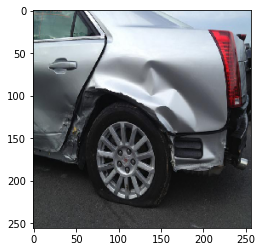

Assessment: Side damage to vehicle
Location assessment complete.


In [0]:
location_estimator('https://www.side.cr/wp-content/uploads/2018/09/Connecticut-Sell-Damaged-Car.jpg', model_final)

Determining location of damage...
[0]


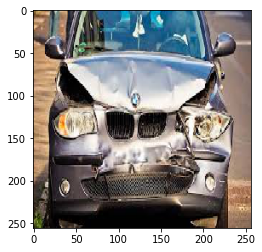

Assessment: Front damage to vehicle
Location assessment complete.


In [0]:
location_estimator('data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUSExQWFhUXGBsYGBcYFxgXGhgYFRsXFxoaGxgbHSggHh0lHRUYIjEhJSkrLi4uFyAzODMsNygtLisBCgoKDg0OGxAQGy0lICUtLS0tLS0tLS0tLS0tLS8tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0rLS0tLS0tLf/AABEIAKcBLQMBIgACEQEDEQH/xAAcAAACAgMBAQAAAAAAAAAAAAAFBgMEAAIHAQj/xABKEAACAQIEAwUEBQcLAwMFAAABAhEAAwQSITEFQVEGEyJhcTJCgZEHFFKhsRUjYoKSwdEWM0NTcpOywtLh8CSi8XODw0RjZKOz/8QAGQEAAwEBAQAAAAAAAAAAAAAAAAECAwQF/8QAKBEAAgICAgEEAgIDAQAAAAAAAAECEQMSITFBBBMiUTJxYaFCgfAj/9oADAMBAAIRAxEAPwDXA2MYkkWwSTOoiNhp5aCr5fEgS1iepJ2qzjMTbQeC+zt0XUftbVTfHXXtnM2kxlzQf/FeUop80en0eXOKfm2HdKGIIDg7E86WeBXrljHM6mDkGYkaMDM0YvJpA01H41SwBDYi6fskJPoP969D08Uos8/1cnsGbeOfOzKTJ1J6zJqxiOJN3bltsjTPoahtXIbXbyiaqdr72XCXWWQrDKCd9SAdqwyJSyUdGFa4rOc8Nlh3aqSzEKqjdixgAepIFOHaC8mHwq2UggKUBHvKviut+u7gf2X8qEdkMKe9N3lbWF87tyVT1gZ2/UFFMDhhjOIpZ3t29W6d3ZOvwa4SPRx0rvk65ORdDb2awi4LBLeu6My9/dJ3EgFV9QsCOpPWuedosS164147uWHoIJC/AKop5+k93fCBLRBKkPeUe1kDELp0kT+rSJauqFslxmVWtlxMZlDKHE8pEia5497CiiPhb/miRupn5iT84omLwiSY6zpHzodgEtrdvW7T95akFGIglTMZhyYTB8xVbj2L70WptguEQMJy5iihQ0z7RHzG40rpw5pY5cLsyzYozXLoNIwYAgyDsRzreaj4Pg27pQFOkwGKzGYxMGKtpw+5MQPiyj75r1IytWeVLVNqytcbyo7gMG5toQp1Ej0O33RVUIUEZEYwZPhYbzInTaB86juYy7MnN+0D901UcjXRzeowLLFJhDiXD3S0bhUjLzkcyF/fQyximuMlv7TKo9WIH768xmMLWyC3w57jzqfsfg7t3ETaALWke4s6AOqnu5PL84U+RqMk+HKRp6bD7dQTbCH1Qpav3SSe5KwBGxYK2b9IZ1MdJoM/aF/c0PXpXTsN2aW4MSjF0D3LhgREXLfdzruRAYR0Fchx+Aezce1cUq6mGHnv8iCCPIisfTzjktM6vUQlBKg1wlC9nPqTmbMdzmmTPnBB+NG+F9m7mJtuVcKIYLOpLRoPL1pU4ZjRbXLmI8U+Xx0o9w3tKts5lOUxDCJDDzEiuqc5uNQ4Z5C9PGOXea2T8eRUuYW5b0uIyGSPEpGo0MTvFWLFuRRTtLxk4p7ZLSEUwIgDMQT+Aoct0bUlKVcnYop8rr+QrhUAjlV35fvoKl6dKl+tRpNZyVmi4LmMsq0aa1twJe7uaHwtp/A1St3GaStQ2MXDCetFNqiemmW+3OBNt7WKTnCsf0k1UnrKgj/2x1qTDYhQQ49lxm9A0Zh8CAT6HrTBirH1nDPb95l8P9tdV+ZA+DUj8GvzaKxraYMAfstuCPXf+1XI1tFo9XBKmM9+wD1rMOETXLM9YNecJu99ZB95ZRvVefxGU/Gt3EaRXE21wegkmbnGJ/VCoHxa/wBSK9aKjNCm0LVEVzGW/wCoFUr2Lsn+hirxqFkHStFkJcBexASfCDHnVQqKZbuHU8hVN8KJ2qtyXE0PE+7MMjDyYEVvY48h3kU8XL5c+NA/k4BFA8X2VsuxYKLc8lOnyNedHNDyjteOS6ZDhcVnGZYyKwzuxhVnqev6IknpVzh2Ew6i4e/zOzFvDbbKegzGDy3iuYW+PXjAnwL7CwAFnyHM8zueZo7gO090QCEI9CP312wio8HHNKbtjvcZVMkgD9IQPSZ/GKFdsMUDg22gkQF1jUcuVFuMcGfF4C1iMJ4pB75PaII5L5DpvqNaTfydcFtM4Pdlgsz7wMEEcmGpjypZMeNyUol45zUXGRY4ezWcPmGjAFxp/SXMqW/2ZBjoGpk+ijh2WzexDCDcfu0nlbs+H/FM/wBkUr9qbjAJaTVyc0DcvJtIB55je+S014i7ibCfVbQtNZS0tpjLLe71wQWBMIMxJI3knflRlfFGMnXAlcZ4q927ibysQC5A/wDTCqFBHTYkdZodZYfVzrqA33Sadzw76uGD4ewVGrE+PMSI9t4WfIEelCMDjLIDKmHuBWkgZEgA8hN2Y/jWfuccGeKezddftC5wdiLzgfpfiK94/fKXD3TkA2ER8pOsg51PX08hTHdx4s/nLdou32CI0iCZEjflIqjie0i3JD4Z0Y84WPQkkDlOppqTbs1ZX7NZmsc9GI58wD++jEHuGGubvEjecuW7PwnL8xVzs3xiyltkK3NWnRC3ID3J6Uat8Rsttm+Nu4PvK1348/xSOHLgezYl52HWve+PU/OnLF3LZE5M/kFmgONwjXGGSw49EbX7q6Y5k+0c8sLXQIa5Ohmnnsd21sYWyLLYcjWTctwS56sGjX47DSKWh2fxW/1e7+w1et2fxW/1e7+w38KWR45qpP8AscI5IO0v6GDiPbXFW2P1dgLTy6B1BYBmYbyeak896VMfj7t+4bt5sztEmANhA0AA2AojxDht893+YveG0q/zb7gsTy86HvhbiGGR1O/iVh+I8qnHpFcUOayS7siyioi0VZ7piCYMDcxoPjVzCth0tEvlLfZnUk/83rR5EiPaYGSSYFXjgTCksqQNZIkmTy9IqO5iACdVWdfs6HaPKvEAOuYH4zV7WZaUH+HJhFQLcUO+5uDEG3pyAUpl+ZJ/CreG4PhLhA797SsRJuKjiBM5bqHLz94D91LbK0akn4moElDK6Hr69azeNvpj9xLhofu0/ALeE7prTMUclTmIMNGZYIA0IDfKky5jkBylJ5bjWpTxe79XbDls1uVYA+4ymZT7MiQRt4p0NR3rSkAjfQzRji4r5chlkpcw4D/ZzGnMUOkAEDTYaHb4fKgnE7H1fiBjRL2o9L37hcBPoorbAX8l9DPMA+jSKI/SHg5s2r32WNs+jjMPkUP7VZzVT/Zv6eRW4BdyXmt8nEgfpJ/sT+xR28RoCCZIAAEnU8vhJ+FKyYsLcs4lhKyjuBpIJyXY6alo9KIcZCX76hLy/V7F0FnzBWcqdCqzmCxs3Oa4skPlfg9aMuAsyLmIQAdM8Ex5jatXRgJa2jDyzKfhlMfMGp+KdvrBJ7tQoGxAAJA9KU+I9ri3vH51SyxqtSPbd3sFO/ts+VMymJyPGaeYBGjddgfLSvLttuh+VImLxrXWVbcm4SMsb5twQeUbzyiuoXePXeifs86wn3wbxAptt0PyNRNbb7J+Ros3HbvRflWv8pb3RP2am2PgKiOo+dTWyOq/Oo3xaHcT6LW9u/b/AKs/s15jR3Jirx36PbV5zcsXe5ZiSUbxW5OpKwZSTrGo6AUvXvo+4gnsi1c81uAf4wtdTV9IWySPSvQX27lx8K2jnyIyligzmPDsNxzBhmso1tfei5ZYH4FiPjE0X7LcBx+KW691bmaQ6FrqFe9JALv4i0hJA0J1A2q19IfF3Sw4USFykgg7sQAXjYdB/tXM+E9p7li4t1AAysHlWZZgg5TBgodQViCDXZinKUbOWajF0dZufR5ifrFu81yyFtvbbLLElbOSAfCACcpPPVjRXj/DExEo963bHMhsxI6aKfvFN/DeL4PGWRcsC3dtmPdU5TvlZSJDDoajxHA8M/8AQovmqhT/ANsVaSb+f9GM+ekIY7L4GQWxRYhco0JjWdPCNf41dwfDsBa2vMT1ykn5TH3Uw3eytjlmHx0qpc4SU21HpW+mF/Zk/c/gqscAAAEZ438A+cMpqI4nCr7Ni58Mq/glWwkVuiCatRxrqJNzfkpNjrcSMNdjrnI/y1EOI25/mG/vmH+Wi7GNKrXLY6VacfoVS+yBeJWv6g/3zfwq3ax9k7WPh3rfwqo2H8qjOGYbCk1FjTki6eIW5j6qSfK4TWt3iVtDDYa6h/tkfeGry1bZRmI16eVX8TYzLJIIOo9DtSuK8DpvyUV43Y/q7o/Wf/XWDieF+y4/b/3qK5hYrTKByqqh9E/L7LYxuGOxf4OR/iFRvisLsXuj9af8tVHUGomwINNKHlCe/hhAWsKf6Vv1o/hWp4ThH9+2fW3bb8aH/kidyKy72blZS4Z6MNPmKeuL7FeT+C9/JXDHbuj+pH+FqrXexVrkoPpeur/iJFCbnC7ycp9KhDXkPvD5irWJeJGbyS/yiFX7HqjEd1ecfo3FYfMWwfmKpXuybCcjOo1yq9ttB0zjf1y1qvF7w99/mant9o7w/pG/Gq9qfiRDlj8xAt/s3ilBhEYxpluQef2wtWO1uOxN2ylhcJeUZgzNAuEkSAALeYASZmelGrfay/8Ab+YFT2+1d3mEb1UGh48l26YovEurQk8PV0tw9ollZlyOjAkXVMaaHQhj60B/JWJuKQbpS10VBsPtezJEczXVcd2uUIBcw1q5qMiZYl9xB1yxE5o0ilrs12gttjblvLbyO+VrduSoYjKGAYnrlJGh000EcXqNo9no4XGS4A+C7DW3UOMW7qRp4ApnmD4jB8qu2Ow2FHttcb9YAfcJpkPCfq966qA928OoEwPaDR8tRyio3auRTtWmdGqKuF4HYsj8zbVT11LEdMxk1FdGtXBcitLkNR2Uge9QsKs3bcVCRSsdDVbuKdkI+FWAPI/hXk2xEu+vnFed/aH9JcHqZrha+jpJwY1Iaf7VQcRxht2btxRcZkRnCZ/aKgsF011jlrW3fWj75PqP9qwJYGrfMKzHy0FCXPImxS7eYz6vw7KQDfxlw3WB8UWw0Wt9xHiE81muMukV3/tPwHD47CG8hJxSWUtosnL+YLHKq6CWzNBJ94ec8HvW21JBr0sdUcE07JuC8axGEud7h7rW36rsR0ZTow8iCK7R2N+mGxei1jlFi5t3qgm0x28Q1Keuo5yK4TFexVkH2RahlDKQysJDKQQQeYI0IrDZr5b7H9ucZw5vzNzNamWsvLWz1ge6fNYPWa7/ANh/pBwvEQFU91fAlrLHXzKN749NRzApDD13hqNuPlpQXiGEyNKzl2+NNRSq/deIzzH4U1NoTimKqWiTVyzgwd6OXcGOQqjftFdTtV72TrRTxGDA2qBVir9qy7yQpC9TpPoK1uYampCopW28UVCXlz05elQXMRluOOYWR8YUfjRbDcKKqGuELOwJj4T1pt0ESq1uonwoNE7litO4o2CgZ9VAr3u6InDGtThTRsKgc4rMJc1Kmr7YEmqz8NuAghSfSq2QURvFaGzm3E0f4dwpSnjEmev3VeThyjYVDyJD0E78jBtlqN+yrMdE9CDT4mGHSpVtxS96S6D2o+Tn79gbhiLiAeeYkfdFDOL9j7+HVrjZXRQWZl1ICiSYMH5TT7x/tDhMGubE30taSFJl2A+yglj8Bzrj30g/Sb+ULLYLB2rgtuRnutAZlVvZVAdAWC6k67QJq16nIvIn6fG/AkdouLPeY20BOsEjWFMQg+PtHrpsKt8CwFyw9pxo/d3C0folSnycodOnlVjsvwdu7zGBmI0Ya8t9dOfyFdO4XwZLOCuC6RnvBVBgeAZpQAHoSWP+1YqTnJtm2qjFAbtZcxGJ7hsKyIchJc+0i3hrkMSrFSykjrVxxRDurdu2bXd+IxkefZRYAXzMT671TIrDr4rpG6XkrMtQuKssKjdKEx0V2MjWoHtdKsOKhNPsQwNZ6HN65axcNPtWjp5j9xrS2MQOnzJ/fVu293mB864W6OmjyzgUnRXHx/3qtxfG27RWyWILgkzyUQeWusgfEDmKu47F9zZe8wnKswI1OwHlqRrXHMZxu5cum8X8ZJ5aAHkPKtsONzdsyyTUeDotnioQkxC6QDuAOcDQc9NSZ5QABPGuD2LjtcyqA2bvBqpUtBLzAgEtMydQeopf4fxZ7pyKjXLnRB+M7Ux8N4Fj7jABEUQBBZmaOnh0G3M8q6Zax7ZirYkYnsqS5Nu5ajKNCSDOx5EakExOk9KD3+F30Jm2fUaj5jSu+YXsHayB+8vF9ZKXGyzrpBMGss9ibaeItfcfpBH305LmqVkYnFHz63D2HtQusa7z0ga1Gq3LTK6sVKmVdSQQw1BDDUEV9CYjsnhkguXM7DKCfkqSOW/UVN/I7Clc3cuPUXBp5gJHzqvcf0TovsD9i/pSutaRcXZuFgIN4ZArRsxUkEGImAdZiJgO+H7YYS5BF0D+0Co/aIj76WOz/ALWCx2QKGGLSFN094hNrMcqyCQYY840XrFOWK7OWnBnD4cGIzKO7YejqoYfA0++Q4QRwuNS4JRlYdQQR91WAa5X2ktfU2PeYpbHskZh3/tlgoUW7CuWm2dSTHM0LXt7h7e3EcW2h1FgEaHUxdRjyI+JoVg0vs7Q7jaRUZRWrk9n6UcM0K9262oEthgDLbey4GvpV7A/SRhGIFvFlQQT+etQoA0nNlmJgDXU6U+SeBw4zweJxCSLiKYETmjUD5gH4Uu8Mwy37RxWIy4gshsXrKCX8TMAGObkD5Vbwv0g2wYdrF0fasXUJ+NotmB19KEYr8mPiBibSXEvqwaFVBmb0YHbfXQRpFXHLry+SJY91SdDD2Zwjhryad0CO7A91dRB1IzGNY0nUATTAMHSdb7cZX7pLR6ki1fuEbAlotxzGpYipr/0h2bft3rAPQuin5Ziajd/RpqNwwYrcYQUiP8ASnYAkPYO+nea6an3OVRt9LmHHK2dtrjc9v6PnQnYqOgjDCtjbA2rn+E+l3BOYd1tnzJYfOBV+/8ASNglgm+IIkZVdpB2OgOlFjocMPbgRUsVzXG/S3hVEol64OqoFAnmS7CB5mlXtH2tuX76pje9TBkEmxYJGdSSq95dGrgiWhTG2nMqwo6P2h+kDC4YMLa3cU40K4dDcAPRrg8A21EkjpXKO0/0mcVvgrbUYK2fsybked0iR6qFpn4Jwvs/cgWg1onk17Ep/wDJp60zr2JsATaN8ryNvF3z9xuEffS2+h6/Z86PgWuvnN3OW1ZzLMTzMkyfiaPYXg9rwopc5pDMIHhEEkgyANIiZ18pHah2NWT+evDMIIco8jpLIW+/lWW+y+HtOrstu5lMkOgSTyOZU19NBQ22UqQjPNkW3uWnSVzgMsZixJnSR6c4AJAqo/Gblx1k+ESFXlB+6T18uXLpPaz6zft92lvBNm9nvL9zN0zKFT99It3shjE3Wy39i5rrpOWCdPKa6IZYqKiZOFy28l7g/GFuDuWaWHssdJ6/8HU8qtXF5Us3ezt+0fEO7jUNcJtrI13IBkfD1o3w034y3lIYbMIKt5grpWOSu0bQ44JLgqEmrLrVe6tZFkVwVXKVLcFRMTVCGp2I91o/a/CtU4iBpqPKCP3VQtYtd84+Mg0RsvJ01+INedR1pgP6QOIL+TroB1Y2wPOXXQT5A/KuYcG4QL+pdgBnLKo1It91oDyP53X8OddF+lOx/wBCGCxluoTtzzLy/tVzfgHEGsuCpAIOZS3s5oKlX/QdTBPIhTsDXf6df+bo4835nUew/DbXdPcS1FtGCBQCczQCWbm0SN559KbOFYhO7uuukALGoIzHX00B1oJ2J41g7gNhWFm4zZnsXDDIxABCz7S6Agid6Zot27htwMjiGMj5/j868zNHIvUKUl8f2duKUXgcI9/9YOwHG373KBIeAAI0AS7AHKM9s/dRfiHEyjBDBOWTGkxMx8RVe32fKhe79oH29trd9AR8boMeVMGK4YjHO4khQNfKSfxr0VFtcHA2rAHEsYWtKUZlZ9J2Ya6H1IEafaJHKphecWC4Y7Kdc2xO8ge1OsDb0NUMRxnCoWS7iLKToqm4mfTnlJnnGWJiOdSrx6woKK925oNLdi867awy2457T16UkpD4A+PsBs9lWBvJGLsEk6NbcByNoWSjEcyzU5XuLA20uDQOqsPRgD++kLD96+OOLaxiTbFo2kRcNdEKd5zhRrLGNhIHKtbWLZbVvDR/NLkJG2hOX5LlHqDWsU65FwwD9Mt3vbYPMBI9Fdgf/wCorj42Ho1du4/w43rUHcTrGaAwykxzjRv1K5Nf4Yy5kI8SBgYI1LkRGmoykMDzG0b1pEmaBRH4r+Fart8P8wove4cwYwpgO4mNxYQGduetRWOHMxC5dSUTz8Y7xviBvVEUUGB19W/DWum/RR2nu2UvWixKqEZZJkDxCPTSkR+HsE7yIBthusG6z5FMbEojNryFPv0bcDLYXGXyNHDJa5T3avr56sB8KmT4KiuRc7d8exGKxJUliqFYQEn84QJ0G5BYqOgX1lVvKy+EyPdiTpDTlj15daZuLWR9axAI0a5dceHN+bY57TCORlfg9WPyUA8eGM4UxyGTPcBH6P8ACi6ChSVGJls0eIzqdSPPrpXi2GPJoBA5wNOtNb8KbLzDZEGfX2nc5DJG2US3TSYrMXhAFzgkqHcZvcIdZVAdwRBJEaCNRIk2FqKiYRjAAkmAANSWY6AdSa6twvh4tIFAUkaTAMhQEBzc5VVqj2M7FXDdS9eBRVAy5okkCAwAMgDQiYMweQzPh4HJhQPwHwpOSKihO7RC7ftfVbft3SFAHvQQcvlOmvSaE9juIk2jhr85QYVj4e7JbIFYnXKzKQZGhAbkxp84t2LxT5Xw9xFMZWDBtiQZGXWdOZA6zpALiXZLitrCi2ti2yrcNy41tkGcAiMys2ZhoS225A3YtPD4KbpjN2T4VcdxbFi3bsWyAbt5Rde80kMLVosVtLKnxMCTAPkr9xW0LOHutay2iEaGFsHKY0OURm9Odcx7H33W+qOLq4hTaTRiAbbMMrup0YZSwLQT4FPvaP30iY63awZF0kJcdbbZQScplmiNZhSRGpMAb0l+LYn+SOV4zjvFxeKLcvOS5y+HuwRqNVOg0gxMDXfemzhYxIt3frN8W29pkBFy4IUKx8EhFJ1iB6zrS72Iurau3reORYvKww2JGW211LhPeBWQjNmhWgeJSWU7gU24fsy1oKLdy4qCXaTMgyPE+8hcuupGXfecslrhlpp9FDCcMNq4uJtYt71tg2a25EaqSIPKGUEAgHwkzpBYfq2IcnNcBtspKgGCZA2I5eYPnQbs7wcqWRSGViSXBGVJ0yzvmIjSNIBmnmzbyKFUTA32gDl6VCjKatsbkovg57wvimKti4mIW54SqoXBhwQSRB9rLG/mK84ldS3YfF4lLVq2PZAUpcuEa5VyMJJAOvLU7A0c43xsDEOhsd9kUZEQw5uEmS5PgS3AADMdSGAB0BGWuEXrjticXcFx4i3ZUfmbC6EBZGZ2kAljEkDTRY0hBrtinJSdpUK3AsU7Aq5kxnAIbMqsdAxYzJkQDrCydGEkLi0O4Gv5/Eseqj4+Mn8RRZ60lwxx6KTioGFXLgFV3WpGw53AG1qfiP3isD6k/VifMR+41omObm6H4/71PhsV+kJ9f41xUdPAE7fXc/Dry9y6wbZk7CLqTrXKsDhc7Bf+CuwdusSTw+8OZyKJI53EFcjwL9K7vS/h/s5M/wCQQsYQOMjgMBtPLX3WGo+BFG+H2sSulvE4lB9nvM6j0V1Onxqrw+JGY5fXT40y4LF21ibifNf9VdTjF9mX6CPCbfFI8PEHC9DYsH7yJoseGXrgy4nEXb/k5AT+7tqqkf2garYfjVlQJuWumty2P81Wl7Q4cf09j++tfvalqhck2C4DbUgKAB0EqPkNKbsDaCgClO32iww1+sWP763/AKqI4btJYOov2P760Pxak4hbGzSKSOLMFuGVgsdPOi1/tNaCE57XqL9j/XShjuLWnvC73isRlUL+cbc6QEQrvzzdKSj9jTDljCnQxFC+LdmbV2SFAJ3iQRrmIBUggEwSvsk6kE0Oxnatxdaz4SwYrAPTT/mlMHZFLpDte290DpScK6Kv7Et+wKD2bl8Tp/OLG8/1U79Sd6nu9gVI/nbxMsdLiz44BH8yOQ+811bCYZHXMRlHKY1r3EXLVrcj7qj5BaOZ4P6PkbS4Ll0Zg2W5czKIBAHhVGA168hTvg+zpRFRcqKogKogAdABAAozir2VQyAVTw/HF7zuz7UdKNWxbV0LnFPozw94eLUcgS4A8hkddOgMwAAIAAFQfRNhp9knUn+cugSRB9/yp44bxE3XdQpheZEUK4u9xWIVyPQ06YrAmF+izBLBNgMQVMm5d3XbZ/Oj1rsxaQKFS0mScpVFBGYgnxATrlE66wKC3rl7ndf4Ma0coy6F83OWJpUUNFrgyDmCfWpQ1u262yMpb2SdiRrAPWlTB4dSousug5HnFS8Rxve4du5V3ZGU91mG4YGVY+yQJMj75opByNGPx4tjQa/woa/HSB441HwpKxvGWDZXe33oGge/a5CdbYYHl1qrfxGOugALZdY923dK6csyXfwp2g1KPE+M/wDVNibYyXrHjdRvctSBcIHOPC/mZ610/F8fsXLdkkg94uYD5D+NcoT61hbouHCpcRly3UFu7NxJ2Jd3II5FYIOuo0rfgzW2JREJAINlWuFH7m4SUEiZdWDIR5eVD1/0OjoYwKWyXtXHtBiCVVgyH/23BUTPugHzqhdx99XdDh7VxXUeIXbgQySJa0zkKNOU86H3L13nhGPkMT/GzVa/ibhj/o7gI2K4pfl/M1OsQ5GAW75dLllrdmJDpCLnB5k5LhBEecgnyII4jh969HeYogD3bKi2dQRBcy3Pdchrn2KxTkgumKSNNGt3dAOsW6y3xnJ/9RcXoLltgfjlDj76uOKPVktsfcLwBLQhAAJnqSTuSTqSep1NEDa8JFImD7XuDAu238s6z8pmmPhXakOwS7aZCecaffTeFrlCUxM4QuW5iwRtiCvwCWyP8Rq+6jzHwqbGBDdutbPhe4SD1iFn0OWR5EVAw86wbtm6XBA6elQMvWPnVhhUFwUBQRXhiHl6RMVh4Yg5ka9RXhuhPEYA8m+PMUJ4jx6fCgMbTp/qrkipS6N5OKK3bV7aYaFYkm7aHKNLin91cwyhrWQCGViwOmoYKCpPlkBHLVutNPbLFzhuYOdSNj1NLZHjbpmMehOld+KNKjkyO2Ue7f7B+C/wFeqr/Zb9k/wozZOlWLYrWjOgPaF73UufBG/hV3Cti1YN3V0xyNp4P3USS2KIYUaUmykgVjcVi7mWLF5YGwtXI/CobdrHHa1iP7tx+IpiFok6CpURxsPupIdCc3Frykgs4IMEQdOXSr3Csdib7C3bD3WeAFUEmQQwIgSIKiTy1pi+osxCorq4YOPFCk66NKEFCTqp5VrgO3Hcm4tu272Zy2UtALKpoWdh+cIbcAkQOtJO3yDVeToY4bh8HeAIl7xLl38TlmOYgnYRMRTLbvKqE9BOlcbv9vsRc0tYUArGjeMiZglcubkdc1aWu0fEmJmVB1IWF+PiNOTQkdJvcT7yStu6dRsjnr0Fa4IXLlxVuYe6VmZ9kLz2YilbhnH76iGJ1I9q6vPYCCdTyFG8N2sOpm1AE/zmsTlkaajNpI51k5l6jZ2h4s1lR4ctsDV2KwPgpLH4CgvDcVfvsLthLbrqpcXFBkbqdPQ+hFAu0nExihbRiAivNwDPJCkAjRd99OZ2re1xnuMXevWARavZS1t1YQ6KFJESNgJM7wN9KFkoWg+vxS7ZQZ7dkMdl70gk/C2ZNLPEUxFy8txns21B8SC8bk//AKlg1XxHakMFhGUgR7Dc9Y1PLn9nnGlBcTx1gZ8UHXW0Zj0J5bkbxrS91sPbQ2Xb6wQWUfrA0svdureYi9h1t6QS5Y/FYH40Dv8AEixMl/gvXYb89x1oTidZOdo65eXXfbl60XZVJHS8T2gw9xMl27hxpoy3EAB1/Tny3pU41hUvo9tcQjCDFu1fhDJ1Lqryx8tfTek+7ggTq7fG3zG49rkN+lDgFzMivqNpVvEQQCBlmIEtJ0hfOmo/yJtfQesdmLYhWwz3ASJKWLysqyJIJOVtAefXXoSweDwuFcNZNp33gOgIOo8S5s4jbbqNKDcLxotk5hmOsZMpOYbiCwYesUYtdocVn1s4i5a08OlzSQTKnMNp086b/Yl+gjhuFd7he88D3BpkYKSRJ2b2gdZGo2pfWwoGguKc0EI0MJnMA7BzbJJPsrznWocVjf8A8JGZgZ/MtYMeZs92AfM1HgsTcunu7KXFvmAiPcS/bILKDLwHUgNMEnb0FFA2dC7N9ncNiLYdMdxFWGjW/rIJQyRqIIgxoeY6agHl7CgjTiGM/W+rt/8ADSx9FnCcRcuLirzoLeUwqzmaRoCZjKPTWB610vi+OtYe0166wW2gkn7gANySSAANyaukRbvgSMf2FfWMfe/WtW2+5ctLmM+jzFe7jlPraZP8Lmjt76RbLQ/dXFtGYcxyJBkbCI5tRX8oq6B1PhIkH18jQqHTZzC/9HuKDQ+ItAcyM7H5ED8aK28ti3bwOHYgucpf3pbV3+ABMDoKNcZxykH84AfMN/lBoN2awM4g3e9t3IQwELEqWIHiDKCpifnTcqVjjHkY+5CqAogAAADkBoKiy1PdHz/5yquSa5LNyN6h0rdmFQMRVAK/EOOd4dAMvpr86Hvi41IA/wB/jG34VWuR1j5Ve4Lw/vmJeGROTczG3n++RWqVLgwlJthLtvwEWeHi6bgdnuINFkCVuE5X+A5UkIZAPVV/AT980w9p8NktlMqgZ1KFQFGUhhBHMiAJ86W8HOUeRI+Rn/MKuBL7COEsu5yoJMqPi7KiyeUs6ifOuicP7PYS6qi4lwuVIL2stoKQShKIgK6ESMwJM6zST2exqWrjC5m7q4htXCurKCVdbiDbMly2jjrljnThw3tJcwjZk7i8hlmZLqZbjSzL4W/OWZznMuU9NaWRSfQ415AHF+Fthr72GYMVO45g6qSORKkGPPnUdt4qPEYx7167funM9xizEaDyAHIAQB5CvU1pjNeInEe0l0qhWRlAmVjOCSJkTPoynnQU3bhMNdvtyjO0zvETvzjmNqY7F7LuMymCRMGRsytBysJMGDuQQQSDBxPhyFe8VhG07GN4uW5kRBOZSQDqGmRTE0LD2yGzI5UxBYOZIeVPi+ywJE8iYMVdtXii5QNACNc3LqN9PeXfmsipnwrHUeIb5gVaZEabAt8AtwDWDrUf1R/snSNg0abQYkAcm3Q6GRSJ5I8PjGF4NA8QyNIJGuqZxPi15jcHqKNJjiD7KjXmBMt1bUZj9va5ouhoBicK24Vhz0Ug6c49d12nUVewRZlDBD+qCY5HlG5gof7Q1oaQ7YZHFHj2lEAzplEL7UiJA2zqPFb0ialHEbuaM7zmjQ2g05cw1jKHK7E+A2/06FCzd+xcnTruh0hiJlfdfcHR9KspgrhPsdRBt6QfFBTTwk6m3zbxrppSqIfIJpjXI9ttpESPa2KzqBuELa29WuTIrw4tts7Tm0y5/skABNZPS375m7tpVa1gLx17s6wd5Ou8tzbTVv6QQrARNW14bfI/m25jcgeLkSPEAeZHiWAqys0viHyIlvGNGbZdrhcbwsHZxOgJ0vN4TEVAzESS2mplrjQAvMvuArnW5GYPFuCutXRw2/vkfkZJQHUQZAOUMdiB4Qo8Pjmt/wAm3Nz4SNZzIDIEAqWMAxohOyznBNFxCmBruGJBGs6qQTGvturAeyY8TqP5vQpMkVGcMZ94knSCMxLL4Y90uy7e6yiTDUYOBjTvLCgZRHeWwITUAAtOVSZUbh9SSNKjGADSBew7aMI72205jmIbKdQ277ZmjLkp7IKYCfDbAGdEggyImAROpWZye8SDmERWuKwao7AN6GdcpMgnTbLAkQDoOc0a4lwW4VLAhtcwIOZpj2pA9swATtlAG/iqrw/s/iGVWKwSFjRgQAgVd10aAFjYdJpbIaTAl20wEzoJ/wC2BqDtBMdFmDm3qqW6/eOn3gj5jyGlPFnsjiCNiNohDpHSQPZ1CjzLGdqkTsqUgspJGwhQumqjcmFOvmSSeQo9yI9JCVhi7wF2HkIXbU8gNdtj5c+g9kOAXBba4UabiZEMlSqGCX9TEKPMtp4ZjwWGa1dR/q9traSe6f2STqDME5w2uYzPMTBDQvbcj28JHmt4t+NoUKSChi7N4cWUCAQBy6VF23RL1q0Ls9yl+290DnbXMCI6SwJ9KBjt5YG9q8PQIfxYVj9s8K8znGmoZJ021ylhzp2Kh7vYBfCFRTbjVYGSCNIG0bVz7G2FsreVPDbFy2Et8rReyt17aneFLKQOQdRsAK1tdr1XS1i3VAICELA8la5bJA/ChOP4mt2ArplWcqhwxljLMxJLM7HUsdTHlSjCnZRBxDEWSstbfocl1BJPMK1tiPma3+j+4hvXZBylJWTqAHA1Igcx9+1BOInwkn/z0A03NX+wuY3CAYPdtt4TAe2NNp/551Gd1E0xK5HQO7ska/OYgfxqJ8HZ6z8Sfwqi+Ed/EW2HvE9dQNNQY5dRVNrUGQwK+R3BG8f8BiuO2dWiCt7C2dCWAHLxRIPqP+RtVZsLYG7j9sf6aHpaOViXUDbMWUbbTPWfvEV6bboBmlZ1BBQSPiRpJ+809g0RzJpbYfFZOhO55DpyowvDUUZ1kMBIhrgJ0n2s8R8J12qjgCgW68EuuUxyAkgy0QBLLv0PSiyXJXMQMpXOTsMoJkyY00PyrpU03R56asXuL4pjcQMPsn280qJyj2RBEnlOtBcPiGXYj2idQDuB1ojjrneF8QoyoLgUA7nb92/LX4UFN2J9a3iSy8MS9SLfudaoLiyK3XiDD/wKoVhFbt3qfvqZDd+03zNDF4q45/cKlXjjjn/2igdhRLF0+83zNSrw1zBJM8jOo9KFr2iuDmP2RUg7UXuR/wC1aVBaDVrh1zXWesgE/Mia1xai1oxBPQEiPLQjlQle1uIGzx+qhiekjQ+dBr+LZjJJpUx7Kg2caoO3P7dzl5Z6z8qRtAEkwC6iTE7N5fj1peLGsmnQthnwnH3tmVyk/p5nH7LsRW9ztK7Eki3r0TKPgAQAPIUqzWTRqg2Ghu0TREW/7tT95FaNx8nlb/ubP4FKWprJopC2YyJxuOVv+5sfuSpPy+wO4HoiL+AFK816GopD2Gsdp7n9Y/wYj8DXv8qH5u59WY/vpUz1neGjVBsNP8ozVix2vZaTS5rwGloh7s6xwX6VO60e2HX5UZu9qsJiAblm93be9augz+o6ggjyMVw/PUiXo2NT7UV0P3H5OwXOKL/W2vm3+mql3iCf1ifAn+FctGI862+s+dPUNjot3Ep9pfnUDunUfOkL64ftfdWyYxjtJ9Jp0LYcr7IRECd82sny3iPhNUcTaSBDaxqNdKDr9YbZLh9Ec6fKrN7AYtULtaIVQSSSugHlM0tl9hyzZGl1WdJJ+VN3YW2WvED+rbY8u8tjc7a6/Kkjh12ZbT469ab+wmIYYhoMHun1j/7ls8/Sss3KNsPDHQ4RxM7a6iOmmnXl8TUn5KZpVQx217skCdeRJjadOVaHFNpt/wCI/wCT51quNZSGWAw56SJ5SORIE+lcbizr3I7vCHAA1DTsbbgwI5xEeLrUR4Y52zyN8qn76nPEnAVRAVdFAiFH6I5aaCKiPEW5wfWT++moyFsKC8TS6xmFUgrBBOwMMQBGaQYPrPmO7UXMiBNCQIkDlpAHT2tTvv8AHKyiMVHMqPLfYrFWhgRtruI5Sd+lVbmutZWV6SLYU7NBGuGy8fnIVSQSA0ggaA77T566ai3i+HICQbcGY0PP4GsrKiX5FR5RE/AvDm1APmDWuL4AFy5boJYAwVIifMSK9rKlSZTigXjcJ3ZgspPQZtPWVA+VVqysrZGTMrKysoEZWVlZQBlZWVlAGVlZWUAZWVlZQBlZWVlAGVlZWUAZWVlZQBlG+EY/CKoW/hyzAmLisTPk9tjlMa6grykHesrKTVqhp0xnw3GOHIVICE+VoiJ5Tk36x86IWOOWWMJGk6BSP8tZWVzzwxq+TaOV2FsPeBGaJ6mf40N7ccTRcJ3MQ90wI+whDMSfgBH6VeVlYYopzOjI6gIlu4ARGmn8aZOxLRfb/wBJv8aVlZXVk6MIdje9wefr615cUiQZn1/hzrKyuc2bIiADuZ9TyqN/L79fxrKyqQmf/9k=', model_final)

Determining location of damage...
[0]


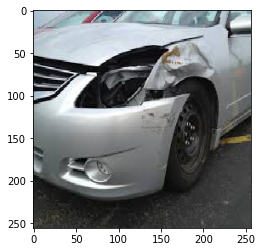

Assessment: Front damage to vehicle
Location assessment complete.


In [0]:
location_estimator('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS9Zi5chHQrhlAxtYupxm5wH2SvYDj2T47XJ3ckLI735NjMi2xm9Q', model_final)

Determining location of damage...
[1]


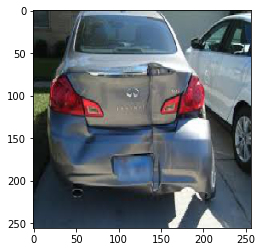

Assessment: Rear damage to vehicle
Location assessment complete.


In [0]:
location_estimator('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQRBUPvifCXSM14dO8WvFcoAQJOVQiRC8ul3YxfvMEb2lFsC0D2', model_final)

Determining location of damage...
[1]


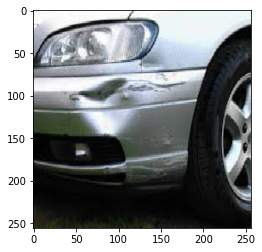

Assessment: Rear damage to vehicle
Location assessment complete.


In [0]:
location_estimator('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcThpYaPbP4xKXPLaTAP-p3BnkgyElfOKbV5o6VNaqt40ZjvevyO', model_final)